In [163]:
import missingno as msno
from itertools import permutations, product
import itertools
import calendar
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
from helper_functions import *
import pandas as pd
from pandas import read_csv
import csv
import unittest
import numpy as np
from pprint import pprint
from setuptools import setup, find_packages
from codecs import open
from os import path
from epw import epw
import sys
from datetime import datetime, date, timezone
from pytz import timezone
import pytz
import numpy as np
import pandas as pd
import requests
from epw import epw
import time
from tqdm import tqdm
from pprint import pprint
import pandas as pd
import math
import pandas as pd
from hoboreader import HoboReader
import sys
print(sys.version)
%matplotlib inline
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 150



3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]


In [217]:
# DL1	Stone Garden - Tjaden Hall
# DL2	PSB Parking Lot
# DL3	Olin Library
# DL4	Milstein Hall Roof
# DL5	Game Farm Road

S1 = HoboReader("DL1_Stone_Garden_Tjaden_Hall.csv")
S2 = HoboReader("DL2_PSB_Parking_Lot.csv")
S3 = HoboReader("DL3_Olin_Library.csv")
S4 = HoboReader("DL4_Milstein_Hall_Roof.csv")
S5 = HoboReader("DL5_Game_Farm_Road_2020.csv")

df1 = S1.get_dataframe()
df2 = S2.get_dataframe()
df3 = S3.get_dataframe()
df4 = S4.get_dataframe()
df5 = S5.get_dataframe()

# DF5 (GAME FARM ROAD) HAS TO BE SHIFTED BACK BECAUSE IT NATIVELY RECORDS DST, OUR STATIONS DO NOT.
# THE OTHER STATIONS ARE NOT SHIFTED (HENCE 0 VALUE FOR PERIODS), JUST THERE FOR SANITY

df5 = df5.shift(-2, freq="H", fill_value=0)
df4 = df4.shift(0, freq="H", fill_value=0)
df3 = df3.shift(0, freq="H", fill_value=0)
df2 = df2.shift(0, freq="H", fill_value=0)
df1 = df1.shift(0, freq="H", fill_value=0)

# Remove time zones (we are only interested in the local timezone)

df5 = df5.tz_convert(None)
df4 = df4.tz_convert(None)
df3 = df3.tz_convert(None)
df2 = df2.tz_convert(None)
df1 = df1.tz_convert(None)

df5 = df5.tz_localize('UTC')
df4 = df4.tz_localize('UTC')
df3 = df3.tz_localize('UTC')
df2 = df2.tz_localize('UTC')
df1 = df1.tz_localize('UTC')

df5 = df5.shift(-5, freq="H", fill_value=0)
df4 = df4.shift(-5, freq="H", fill_value=0)
df3 = df3.shift(-5, freq="H", fill_value=0)
df2 = df2.shift(-5, freq="H", fill_value=0)
df1 = df1.shift(-5, freq="H", fill_value=0)

# Get rid of multiindex

df5.columns = df5.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df4.columns = df4.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df3.columns = df3.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df2.columns = df2.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)
df1.columns = df1.columns.droplevel(1).droplevel(2).droplevel(1).droplevel(1)


# FIX OUTLIERS ONCE AND FOR ALL
def get_bm_from_cutoff(df, variable, smallerthan, largerthan):

    bm = (df[variable].astype(float) < (smallerthan)) | (df[variable].astype(float) > (largerthan))

    df[variable][bm] = np.NaN

    return df


def delete_interpolate_outliers(df):

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # make IQR very small if 0
    IQR[IQR == 0] = 0.02

    # print(IQR)
    cutoff = 60
    bm = (df < (Q1 - cutoff * IQR)) | (df > (Q3 + cutoff * IQR))
    df[bm] = np.NaN

    # Create imputed flags for onces we can fix

    df['Imputed'] = df.isna().sum(axis=1).apply(lambda x: 0 if x == 0 else 1)
    df = df.interpolate(method='polynomial', order=2)

    # Create obvious NaNs and mark them as missing

    df = get_bm_from_cutoff(df, 'Solar Radiation', 0, 2500)
    df = get_bm_from_cutoff(df, 'Wind Speed', 0, 50)
    df = get_bm_from_cutoff(df, 'Wind Direction', 0, 360)
    df = get_bm_from_cutoff(df, 'Temp', -50, 50)
    try:
        df = get_bm_from_cutoff(df, 'MRT', -70, 80)
    except:
        "No MRT"
    df = get_bm_from_cutoff(df, 'Gust Speed', 0, 100)
    df = get_bm_from_cutoff(df, 'RH', 0, 100)
    df = get_bm_from_cutoff(df, 'DewPt', -50, 50)

    df['Missing'] = df.isna().sum(axis=1).apply(lambda x: 0 if x == 0 else 1)

    return df


df5 = delete_interpolate_outliers(df5)
df4 = delete_interpolate_outliers(df4)
df3 = delete_interpolate_outliers(df3)
df2 = delete_interpolate_outliers(df2)
df1 = delete_interpolate_outliers(df1)

data = {'df5': df5, 'df4': df4, 'df3': df3, 'df2': df2, 'df1': df1}

for key, df in data.items():
    cnt_i = (df['Imputed'] == 1).sum()
    print(key, "has", cnt_i, "inputed observations.")
    cnt_m = (df['Missing'] == 1).sum()
    print(key, "has", cnt_m, "missing observations.")

C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


ValueError: could not convert string to float: '0.3-99999-9999999'

In [211]:
# Fix S5 messed up Format
S5 = pd.read_csv("DL5_Game_Farm_Road_2020.csv")
# Create datetime from messed up column
dt = pd.to_datetime(S5.iloc[1:,1].values)
dt
s = dt.strftime('%m/%d/%y %#I:%M:%S %p')

In [214]:


S5.iloc[1:,1] = s
S5.index = S5.iloc[:,0]
#S5.drop("#" )
SS5 = S5.drop(columns = "Plot Title: DL5")
SS5
S5.to_csv("DL5_Game_Farm_Road_2020.csv", index= None)


In [ ]:
def plot(variable_id, period_len, day, resample_len, month, year):

    start_time = str(year) + '-' + str(month) + '-' + str(day) + ' 11:00:00+00:00'
    end_time = str(year) + '-' + str(month) + '-' + str(day + period_len ) + ' 04:00:00+00:00'
    utc = timezone('UTC')

    df1_ = df1.loc[start_time:end_time]
    df2_ = df2.loc[start_time:end_time]
    df3_ = df3.loc[start_time:end_time]
    df4_ = df4.loc[start_time:end_time]
    df5_ = df5.loc[start_time:end_time]

    # Resample subhourly data to 1 hourly graph (OUR STATIONS RECORD IN 10MIN INTERVALS, GFR IN 1HR, RESAMPLE FOR EASY COMPARISON. CAN TURN OFF)
    df1_ = df1_.resample(str(resample_len) + 'H').mean()
    df2_ = df2_.resample(str(resample_len) + 'H').mean()
    df3_ = df3_.resample(str(resample_len) + 'H').mean()
    df4_ = df4_.resample(str(resample_len) + 'H').mean()
    df5_ = df5_.resample(str(resample_len) + 'H').mean()

    # Resize figure
    custom_figsize = (30, 15)

    # Change lineweights
    lineweights = 1.5

    variables = [
        "Wind Speed", "MRT", "Temp", "RH", "Solar Radiation", "Wind Speed",
        "Gust Speed", "Wind Direction", "DewPt"
    ]

    variable = variables[variable_id]

    # Plot both temp and mrt when temp is selected

    if variable == "MRT" or variable == "DewPt" or variable == "Gust Speed":
        ax = df1_.plot(y=variable, lw=1, figsize=custom_figsize, color='red')
        df2_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='blue',
                  ax=ax)
        df3_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='green',
                  ax=ax)
        df4_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='aqua',
                  ax=ax)
        df5_.plot(y=variable,
                  lw=3.5,
                  figsize=custom_figsize,
                  color='black',
                  ax=ax)

    elif variable == "Temp":
        # Plot two dataframes into one plot
        ax = df1_.plot(y=variable, lw=2, figsize=custom_figsize, color='red')
        df2_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='blue',
                  ax=ax)
        df3_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='green',
                  ax=ax)
        df4_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='aqua',
                  ax=ax)
        df5_.plot(y=variable,
                  lw=3.5,
                  figsize=custom_figsize,
                  color='black',
                  ax=ax)

        ax = df1_.plot(y="MRT",
                       lw=1,
                       figsize=custom_figsize,
                       style=['--'],
                       color='red',
                       ax=ax)
        df2_.plot(y="MRT",
                  lw=1,
                  figsize=custom_figsize,
                  style=['--'],
                  color='blue',
                  ax=ax)
        df3_.plot(y="MRT",
                  lw=1,
                  figsize=custom_figsize,
                  style=['--'],
                  color='green',
                  ax=ax)
        df4_.plot(y="MRT",
                  lw=1,
                  figsize=custom_figsize,
                  style=['--'],
                  color='aqua',
                  ax=ax)

    else:
        # Plot two dataframes into one plot
        ax = df1_.plot(y=variable, lw=1, figsize=custom_figsize, color='red')
        df2_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='blue',
                  ax=ax)
        df3_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='green',
                  ax=ax)
        df4_.plot(y=variable,
                  lw=1,
                  figsize=custom_figsize,
                  color='aqua',
                  ax=ax)
        df5_.plot(y=variable,
                  lw=2,
                  figsize=custom_figsize,
                  color='black',
                  ax=ax)

    # Legend
    ax.legend([
        "DL1 - Stone Garden - Tjaden Hall", "DL2 - PSB Parking Lot",
        "DL3 - Olin Library", "DL4 - Milstein Hall Roof ",
        "DL5 - Game Farm Road"
    ],
              loc='upper left',
              frameon=False,
              fontsize=20)

    # Fix xticks

    # years = mdates.YearLocator()  # every year
    # months = mdates.MonthLocator()  # every month
    # days = mdates.DayLocator()  # every day
    # minutes = mdates.MinuteLocator()  # every minute
    #days_fmt = mdates.DateFormatter('%d')

    # format the ticks
    # if period_len > 1:
    #    hours = mdates.HourLocator(interval=6)  # every 6 hours
    #    hours_fmt = mdates.DateFormatter('%H:00')
    #    ax.xaxis.set_major_locator(hours)
    #    ax.xaxis.set_major_formatter(hours_fmt)
    #
    # else:
    #    hours = mdates.HourLocator()  # every 6 hours
    #    hours_fmt = mdates.DateFormatter('%H:00')
    #
    #    ax.xaxis.set_major_locator(hours)
    #    ax.xaxis.set_major_formatter(hours_fmt)

    # we dont have minor ticks for now
    # ax.xaxis.set_minor_locator(hours)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    ax.tick_params(axis='both', which='major', labelsize=22)

    # Labels
    plt.ylabel(variable, fontname="Consolas", fontsize=26)
    plt.xlabel("Time", fontname="Consolas", fontsize=26)

    # Title
    ax.set_title(str(
        start_time.split(' ')[0] + " "
        'to'
        " " + end_time.split(' ')[0] + " " + variable),
                 fontname="Consolas",
                 fontsize=28)


# Variable to plot
# 1 = "MRT °C"
# 2 = "Temp °C"
# 3 = "RH"
# 4 = "Solar Radiation"
# 5 = "Wind Speed"
# 6 = "Gust Speed"
# 7 = "Wind Direction"
# 8 = "DewPt"

interact(plot,
         variable_id=(1, 8, 1),
         period_len=(1, 30, 1),
         resample_len=(1, 24, 1),
         day=(1, 31, 1),
         month=(1, 12, 1),
         year=(2019, 2021, 1))

In [46]:
# Reindl split test
from gen_reindl import *

# Create date series using date_range() function
#date_series = pd.date_range('01/01/2019', periods=8760, freq='H')
# print(date_series)

# altitude M Station (although not necessary for gen_reindl)
altitude = 255

# lat, lon taken from STATION
lat = 42.45062  # north-positive
lon = 76.48120  # west-positive for Reindl split (Alstan)

# Then the gen_reindl program can be run. -l is longitude (west positive),
# -a is latitude (north positive) and -m is the time zone in a multiple of
# 15 degrees from the meridian. The command below is for Singapore, and
# you note that it is in the wrong time zone. UTC+8 * 15 = -120, despite a
# -103.98 longitude.
# > gen_reindl -m -120 -l -103.98 -a 1.37 -i input.txt -o output.wea

# pos
time_zone = 5 * 15  # west-positive

# print("month, day, time, GHR\n")

# %timeit GenReindl(lat, lon, time_zone).calc_split(4, 22, 8.333333333, 107)

def calc_split_df(df):
    idx = df.index
    solar_rad_column = df.columns.get_loc('Solar Radiation')
    GHR = df.iloc[:, solar_rad_column].astype('float')
    
    # temporary bitmask
    bm = df.isna()
    df.fillna(0) 

    gr = GenReindl(lat, lon, time_zone)    
    DNI, DHR = gr.calc_split_vectorized(gr, idx.month, idx.day, idx.hour, GHR)
    
    # back to NaN for missing values    
    df[bm] = np.NaN

    df['DHR'] = DHR
    df['DNI'] = DNI

    return df


test = calc_split_df(df5)
test[['Solar Radiation', 'DHR', 'DNI']].loc['2019-06-06']

title,Solar Radiation,DHR,DNI
datetimes,,,
2019-06-06 00:00:00+00:00,0.00,0.000000,0
2019-06-06 01:00:00+00:00,0.00,0.000000,0
2019-06-06 02:00:00+00:00,0.00,0.000000,0
2019-06-06 03:00:00+00:00,0.00,0.000000,0
2019-06-06 04:00:00+00:00,1.16,1.160000,0
2019-06-06 05:00:00+00:00,19.77,19.770000,0
2019-06-06 06:00:00+00:00,26.75,25.947500,3
2019-06-06 07:00:00+00:00,66.29,64.301300,4
2019-06-06 08:00:00+00:00,108.16,104.915200,5


In [59]:
test1 = calc_split_df(df3)
test1

C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in calc_split (vectorized)
  outputs = ufunc(*inputs)


title,#,Date Time,MRT,Temp,RH,Solar Radiation,Wind Speed,Gust Speed,Wind Direction,DewPt,Imputed,Missing,DHR,DNI
datetimes,,,,,,,,,,,,,,
2019-09-27 13:46:39+00:00,1,09/27/19 01:46:39 PM,27.235000,22.011111,40.0,1276.9,2.668829,6.347968,333.7,7.777778,0,0,461.108191,1188.889988
2019-09-27 13:56:39+00:00,2,09/27/19 01:56:39 PM,27.973889,22.800000,39.8,106.9,1.341120,3.670198,28.2,8.388889,0,0,103.693000,4.673705
2019-09-27 14:06:39+00:00,3,09/27/19 02:06:39 PM,28.841111,23.112222,38.9,156.9,1.001370,3.670198,322.4,8.388889,0,0,152.193000,7.713923
2019-09-27 14:16:39+00:00,4,09/27/19 02:16:39 PM,29.265000,23.112222,38.9,211.9,1.341120,3.008579,347.7,8.388889,0,0,203.991590,12.960456
2019-09-27 14:26:39+00:00,5,09/27/19 02:26:39 PM,29.340000,23.423889,38.6,235.6,1.341120,3.670198,335.1,8.500000,0,0,225.098838,17.209509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-04 13:33:14+00:00,49391,09/04/20 01:33:14 PM,24.702000,24.532000,43.5,785.6,3.010000,8.020000,146.4,11.300000,0,0,199.580144,737.307548
2020-09-04 13:43:14+00:00,49392,09/04/20 01:43:14 PM,25.331000,23.881000,42.7,758.1,3.010000,6.680000,142.2,10.500000,0,0,226.737677,668.539551
2020-09-04 13:53:14+00:00,49393,09/04/20 01:53:14 PM,26.720000,23.833000,42.6,701.9,3.010000,8.020000,143.6,10.400000,0,0,274.533820,537.695621


In [184]:
def get_1y_data(df, year):
    #start = datetime(int(year), 1, 1, 0, 0, tzinfo=utc)
    #end = datetime(int(year), 12, 31, 23, 0, tzinfo=utc)

    dt = pd.date_range(datetime(int(year), 1, 1, 0, 0),
                       datetime(int(year), 12, 31, 23, 0),
                       freq="60min")

    df = df.resample('H').mean()
    df3 = df.reindex(dt, fill_value=9999)

    return df3


def make_epw(title, year, hobo_df_all, remove_leap_year):

   


    e = epw()

    e.headers = {
        'LOCATION': [
            'Ithaca', 'NY', 'USA', 'TMY3', '725190', '42.43', '-76.49', '-5.0',
            '125.0'
        ],
        'DESIGN CONDITIONS': [],
        'TYPICAL/EXTREME PERIODS': [],
        'GROUND TEMPERATURES': [],
        'HOLIDAYS/DAYLIGHT SAVINGS': [],
        'COMMENTS 1': [],
        'COMMENTS 2': [],
        'DATA PERIODS': []
    }

    # print(e.headers)

    #variables = ["Wind Speed","MRT","Temp","RH","Solar Radiation","Wind Speed","Gust Speed","Wind Direction","DewPoint" ]

    dt = pd.date_range(datetime(int(year), 1, 1, 0, 0),
                       datetime(int(year), 12, 31, 23, 0),
                       freq="H")
    
    hobo_df = calc_split_df(hobo_df_all)
    try: 
        hobo_df = hobo_df.tz_convert(None) 
    except: 
        "has no timezone"
    hobo_df = hobo_df.resample('H').mean()
    hobo_df = hobo_df.reindex(dt, fill_value=9999)
    
    missing_values = hobo_df['Missing']

    #if calendar.isleap(year):
    #    #missing_values = np.array(np.ones(8784) * 999999).astype(int)
    #    missing_values = hobo_df['Missing']
    #else:
    #    #missing_values = np.array(np.ones(8760) * 999999).astype(int)
    #    missing_values = hobo_df['Missing']

    edf = e.dataframe

    edf['Year'] = dt.year.astype(int)
    edf['Month'] = dt.month.astype(int)
    edf['Day'] = dt.day.astype(int)
    edf['Hour'] = dt.hour.astype(int) + 1
    edf['Minute'] = dt.minute.astype(int)
    edf['Data Source and Uncertainty Flags'] = missing_values

    # Actual file starts here
    # 6
    # .apply(lambda x: ftoc(x), axis=1).values.flatten()
    edf['Dry Bulb Temperature'] = hobo_df['Temp'].values.flatten()

    #     Add this later (ADDED TO DL5_2019 FILE 07.22.2020)
    # missing_values
    edf['Dew Point Temperature'] = hobo_df['DewPt'].values.flatten()

    edf['Relative Humidity'] = hobo_df['RH'].values.flatten()

    # Added NREL pressure 2020-08-21
    if 'Pressure' in hobo_df:
        edf['Atmospheric Station Pressure'] = hobo_df[
            'Pressure'].values.flatten()
    else:
        edf['Atmospheric Station Pressure'] = missing_values

    edf['Extraterrestrial Horizontal Radiation'] = missing_values
    #
    edf['Extraterrestrial Direct Normal Radiation'] = missing_values
    #
    edf['Horizontal Infrared Radiation Intensity'] = missing_values
    #
    edf['Global Horizontal Radiation'] = hobo_df[
        'Solar Radiation'].values.flatten()
    edf['Direct Normal Radiation'] = hobo_df['DNI'].values.flatten()
    edf['Diffuse Horizontal Radiation'] = hobo_df['DHR'].values.flatten()

    # Do we need this?
    # https://www.radiance-online.org//pipermail/radiance-general/2013-January/009140.html ?
    edf['Global Horizontal Illuminance'] = hobo_df['Solar Radiation'].values.flatten() * \
        179
    edf['Direct Normal Illuminance'] = hobo_df['DNI'].values.flatten() * 179
    edf['Diffuse Horizontal Illuminance'] = hobo_df['DHR'].values.flatten(
    ) * 179

    edf['Zenith Luminance'] = missing_values

    edf['Wind Direction'] = hobo_df['Wind Direction'].values.flatten().astype(
        int)
    edf['Wind Speed'] = hobo_df['Wind Speed'].values.flatten()

    if 'SkyCover' in hobo_df:

        # not sure which one to use (skycover)
        edf['Total Sky Cover'] = hobo_df['SkyCover'].replace(
            ' -',
            '1.0').astype(float).multiply(10).astype(int).values.flatten()
        #     This is from Ithaca airport data (NWS, NOAA) (ADDED TO DL5_2019 FILE 07.22.2020)
        #  (used if Horizontal IR Intensity missing)
        edf['Opaque Sky Cover'] = hobo_df['SkyCover'].replace(
            ' -',
            '1.0').astype(float).multiply(10).astype(int).values.flatten()
    else:
        edf['Total Sky Cover'] = missing_values
        edf['Opaque Sky Cover'] = missing_values

    #

    edf['Visibility'] = missing_values
    edf['Ceiling Height'] = missing_values
    edf['Present Weather Observation'] = missing_values
    #
    edf['Present Weather Codes'] = missing_values
    edf['Precipitable Water'] = missing_values
    edf['Aerosol Optical Depth'] = missing_values
    #
    edf['Snow Depth'] = missing_values
    edf['Days Since Last Snowfall'] = missing_values
    edf['Albedo'] = missing_values
    #

    # We have precipitation but lets not use it for now
    edf['Liquid Precipitation Depth'] = missing_values
    edf['Liquid Precipitation Quantity'] = missing_values
    
    if remove_leap_year: 
        edf.drop(edf.index[1416:1440],  inplace=True)
        print("Leap year day removed.")
        
    # Fill NaN with 999 so that Eddy3D can read it
    edf.fillna(999, inplace=True)
        

    filename = str(title) + "_" + str(year) + '.epw'

    e.write(filename)

    with open(filename, 'r') as file:
        filedata = file.read()
        filedata = filedata.replace('.0,', ',')
    with open(filename, 'w') as file:
        file.write(filedata)
        
    show_missing_vals(filename.split('_')[0], year, hobo_df)

    return edf


def show_missing_vals(filename, year, df):
    
    try: 
        df = df.tz_convert(None) 
    except: 
        "has no timezone"


    fig = msno.matrix(df, freq='M')
    fig_copy = fig.get_figure()
    fig_copy.savefig(filename + '_' + str(year) + '_MissingVals.png',
                     bbox_inches='tight')

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2019,1,1,1,0,999.0,6.72,5.72,95.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
1,2019,1,1,2,0,999.0,7.67,6.47,94.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
2,2019,1,1,3,0,999.0,8.67,7.27,93.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
3,2019,1,1,4,0,999.0,9.44,8.24,94.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
4,2019,1,1,5,0,999.0,10.17,5.57,77.00,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019,12,31,20,0,999.0,0.52,-5.99,67.42,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8756,2019,12,31,21,0,999.0,0.13,-5.92,69.78,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8757,2019,12,31,22,0,999.0,-0.07,-5.91,70.78,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8758,2019,12,31,23,0,999.0,-0.14,-6.17,69.86,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0


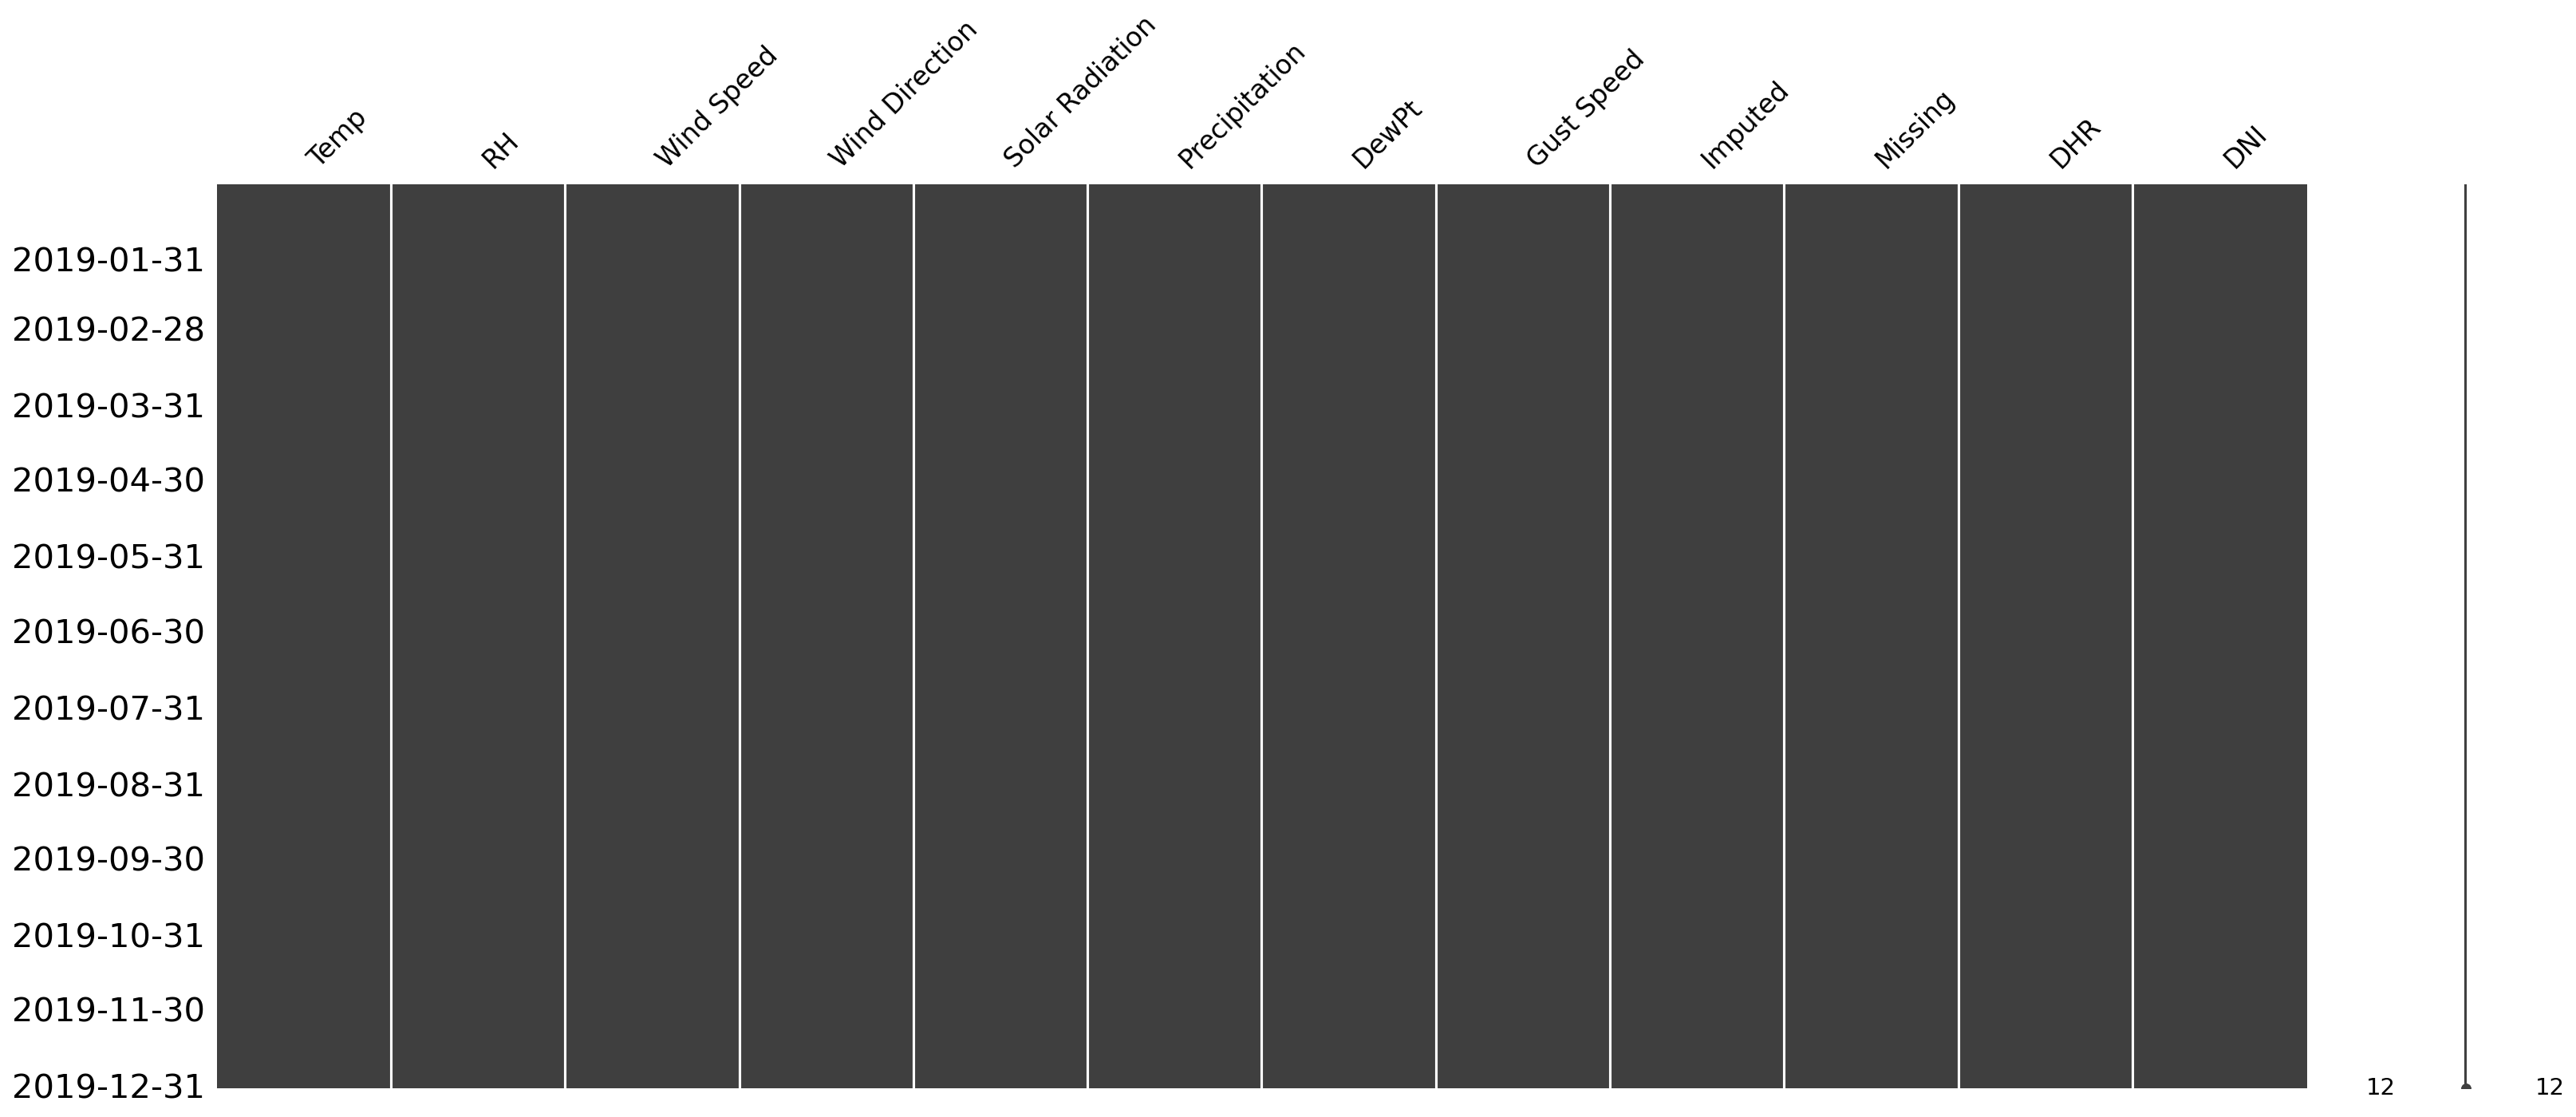

In [186]:
# GAME FARM ROAD_ITHACA STATION

#S5 = HoboReader("DL5_Game_Farm_Road_2019.csv")
#hoho_df = S5.get_dataframe()

# There are about 35 variables in the core weather data. However, not all of them are used by EnergyPlus. Actually, despite of date and time columns, only 13 columns are used:
# dry bulb temperature
# dew point temperature
# relative humidity
# atmospheric pressure
# horizontal infrared radiation intensity from sky
# direct normal radiation
# diffuse horizontal radiation
# wind direction
# wind speed
# present weather observation
# present weather codes
# snow depth
# liquid precipitation depth

# https://www.radiance-online.org/pipermail/radiance-general/2015-April/010841.html

# Daniel,

# You should be able to generate the .wea file from diffuse horizontal
# radiation and direct normal radiation values. The structure of the lines
# after the heading in .wea file is:

# month day hour directNormalRadiation diffuseHorizontalRadiation

# Load NREL 2019 and take atmospheric pressure from there
year = 2019
nrel_2019 = Path.cwd() / Path("nrel_data/1162143_42.45_-76.50_2019.csv")
# print(nrel_2019)
nrel_2019_df = pd.read_csv(nrel_2019)
#df.columns = df.index[0]
nrel_2019_df.columns = nrel_2019_df.loc[nrel_2019_df.index[1]]
nrel_2019_df = nrel_2019_df.drop(nrel_2019_df.index[0])
nrel_2019_df = nrel_2019_df.drop(nrel_2019_df.index[0])

nrel_2019_pressure = nrel_2019_df['Pressure'].astype(int) * 100

# Real file

# e.headers['LOCATION'][0]='Ithaca_NY'

# Design conditions and extreme periods are taken from the Syracuse file

make_epw("GameFarmRoad", 2019,df5, False)

2019 DL1


C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in calc_split (vectorized)
  outputs = ufunc(*inputs)


2019 DL2
2019 DL3
2019 DL4
2019 DL5
2020 DL1
2020 DL2
2020 DL3
2020 DL4
2020 DL5


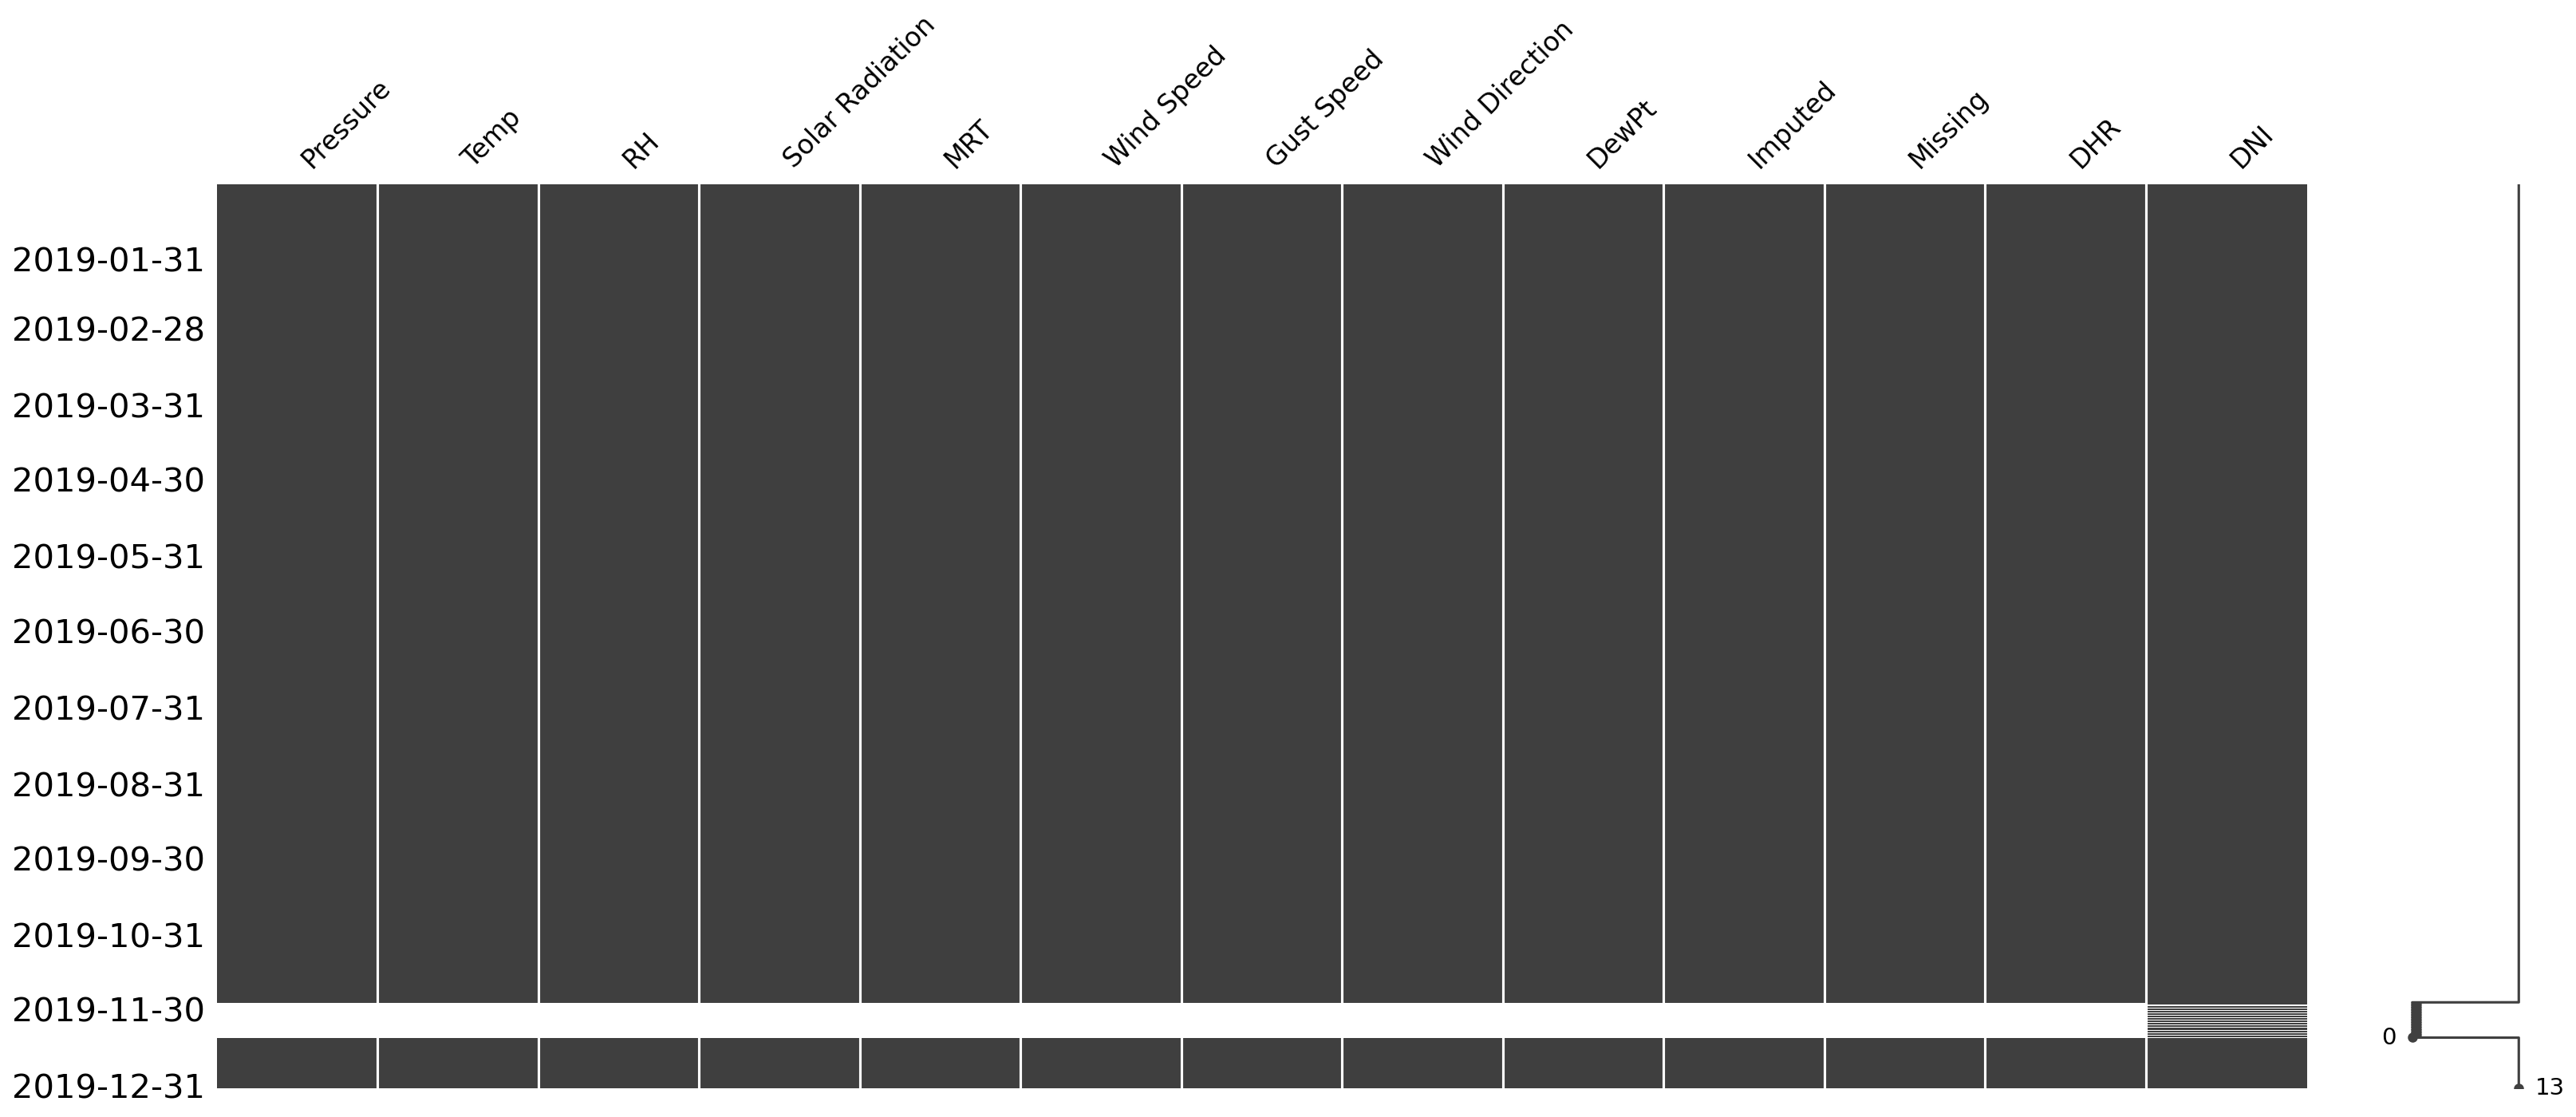

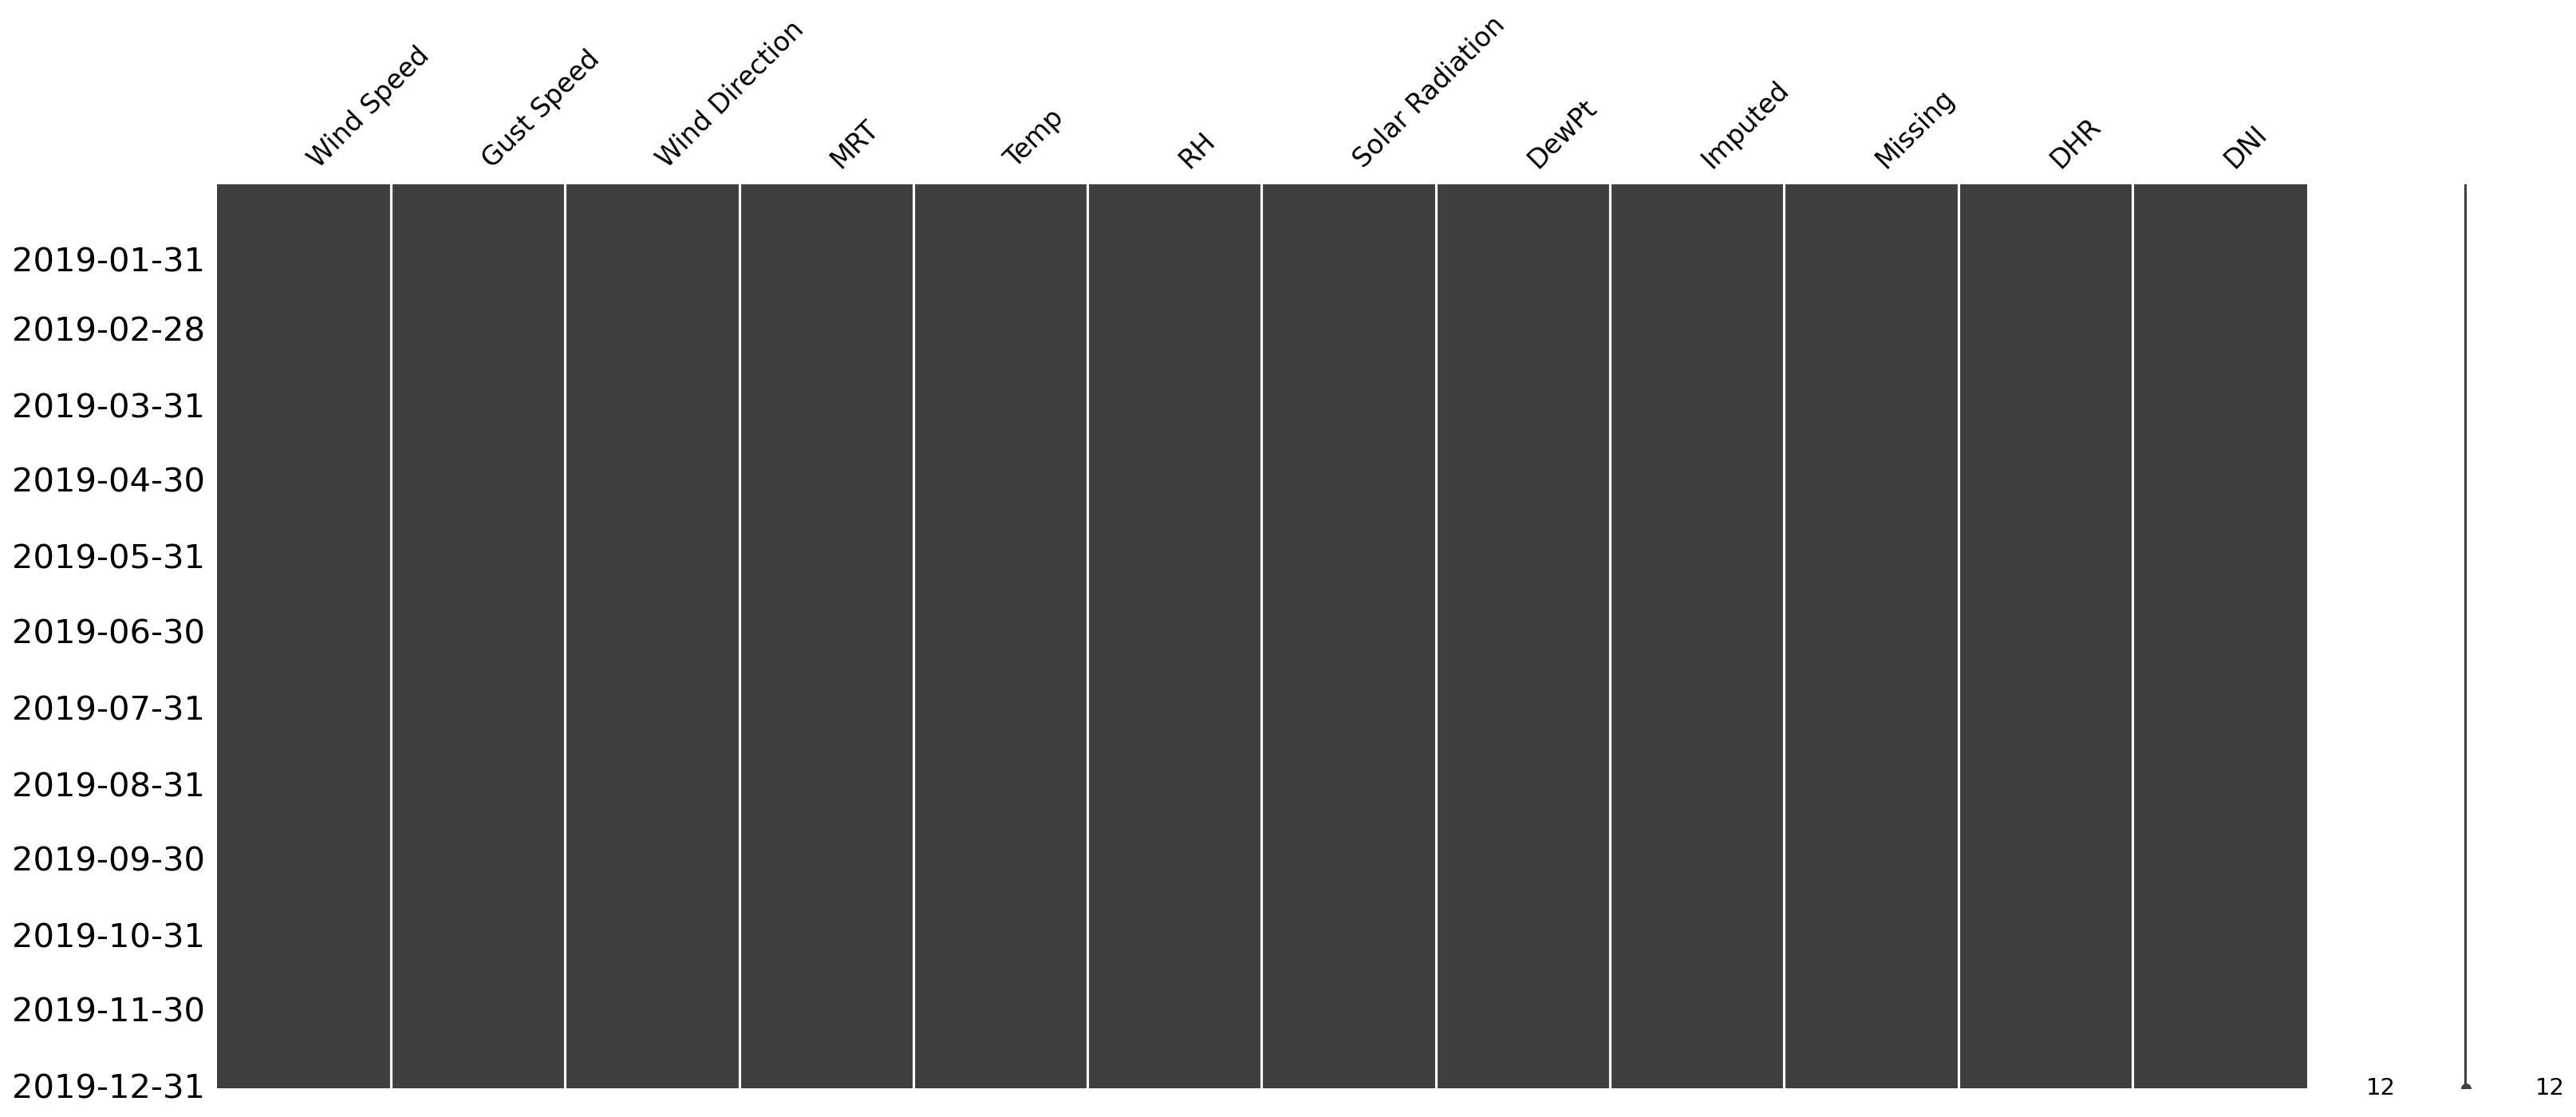

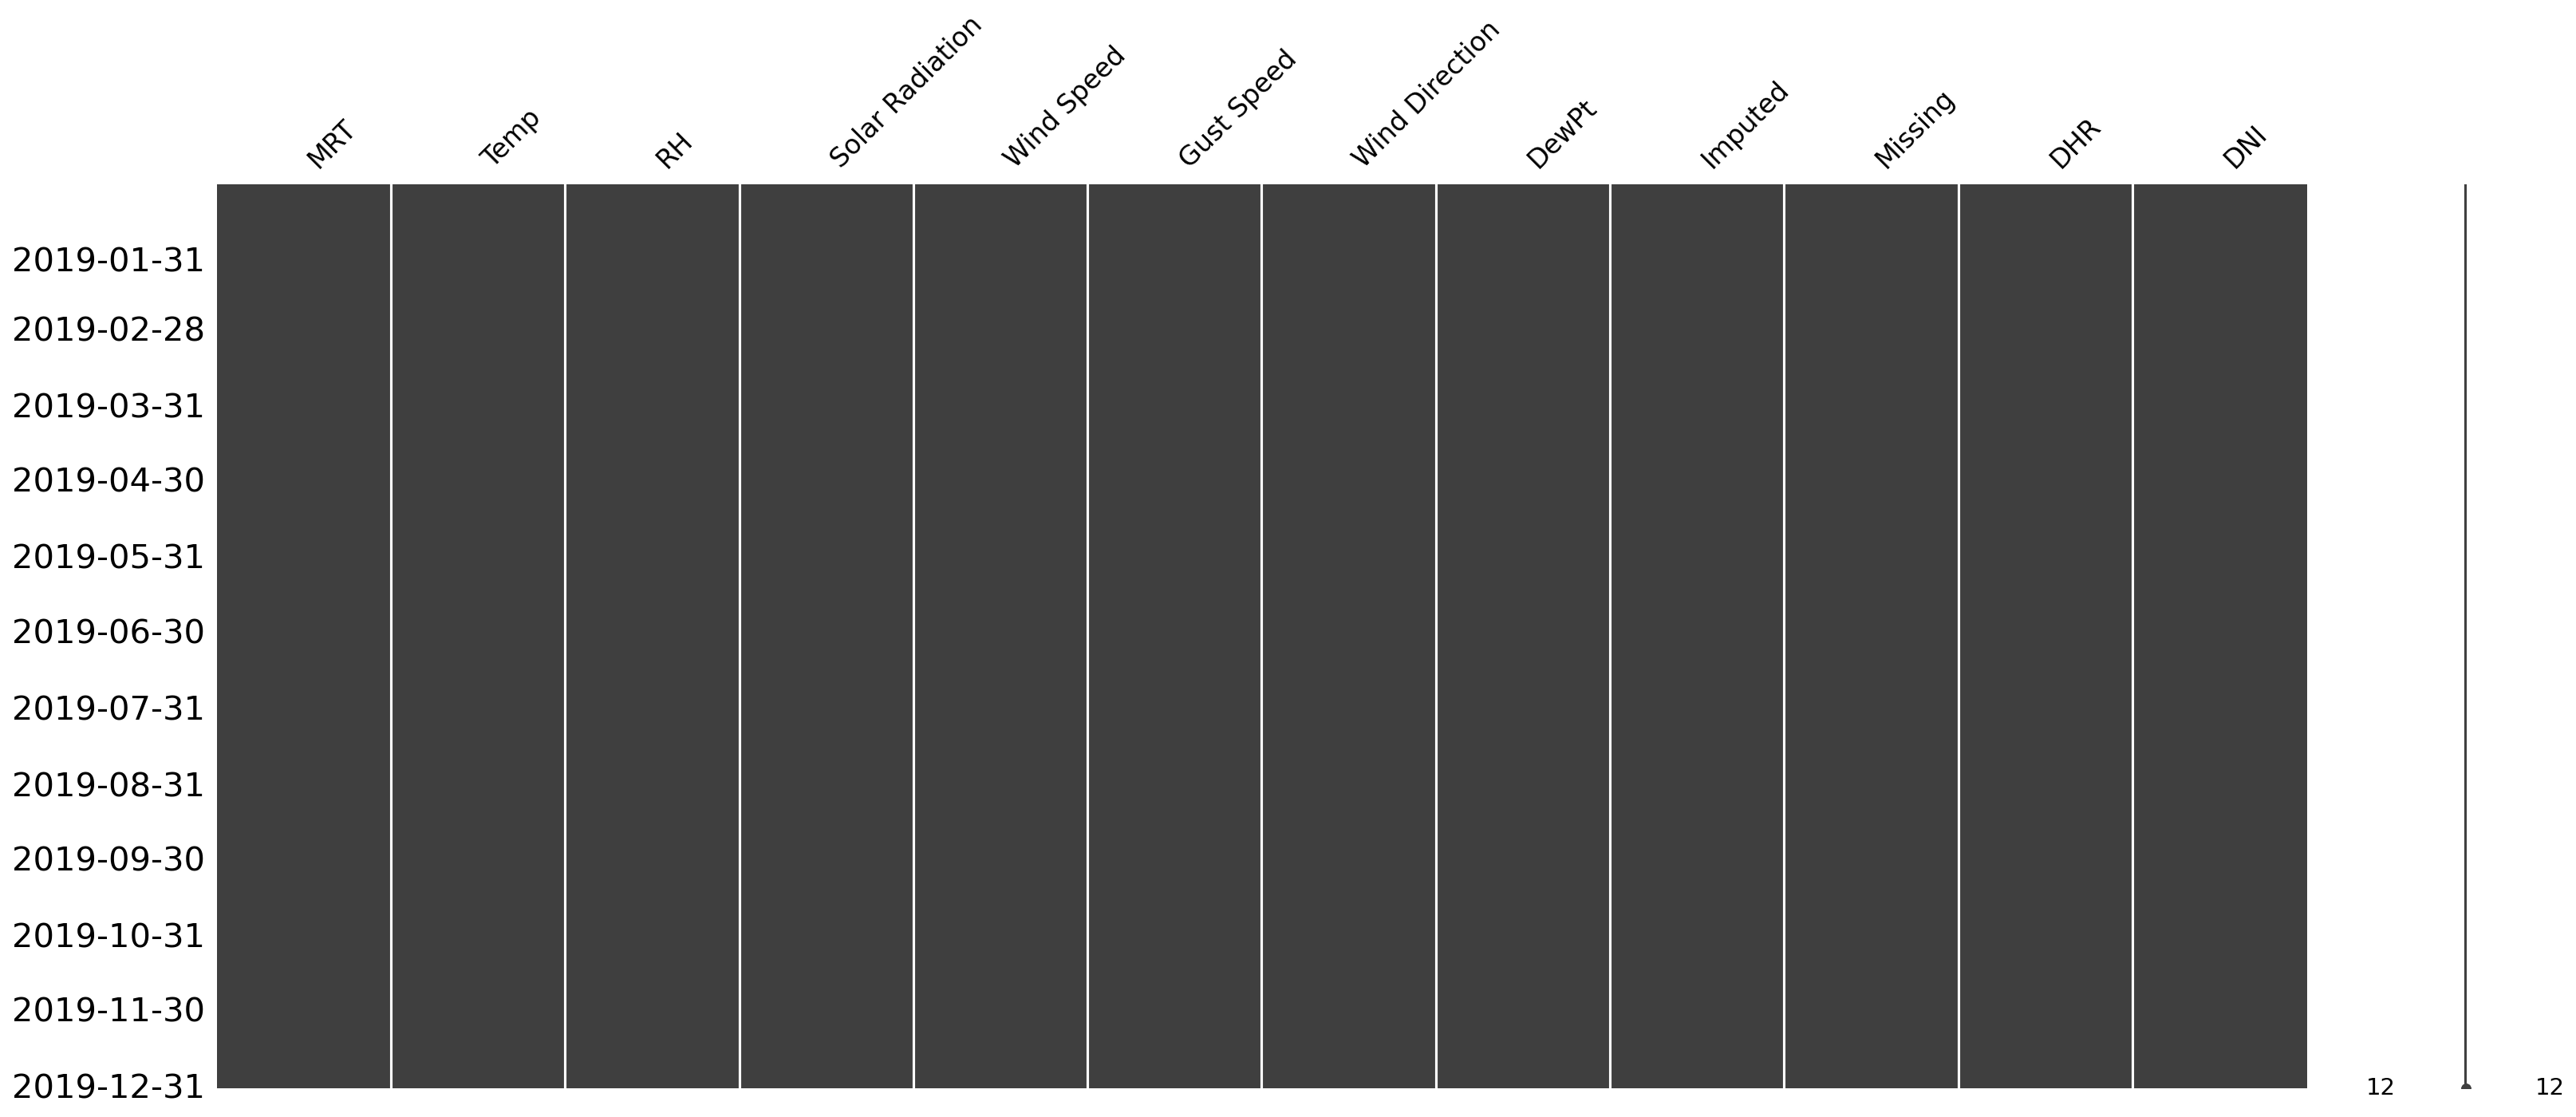

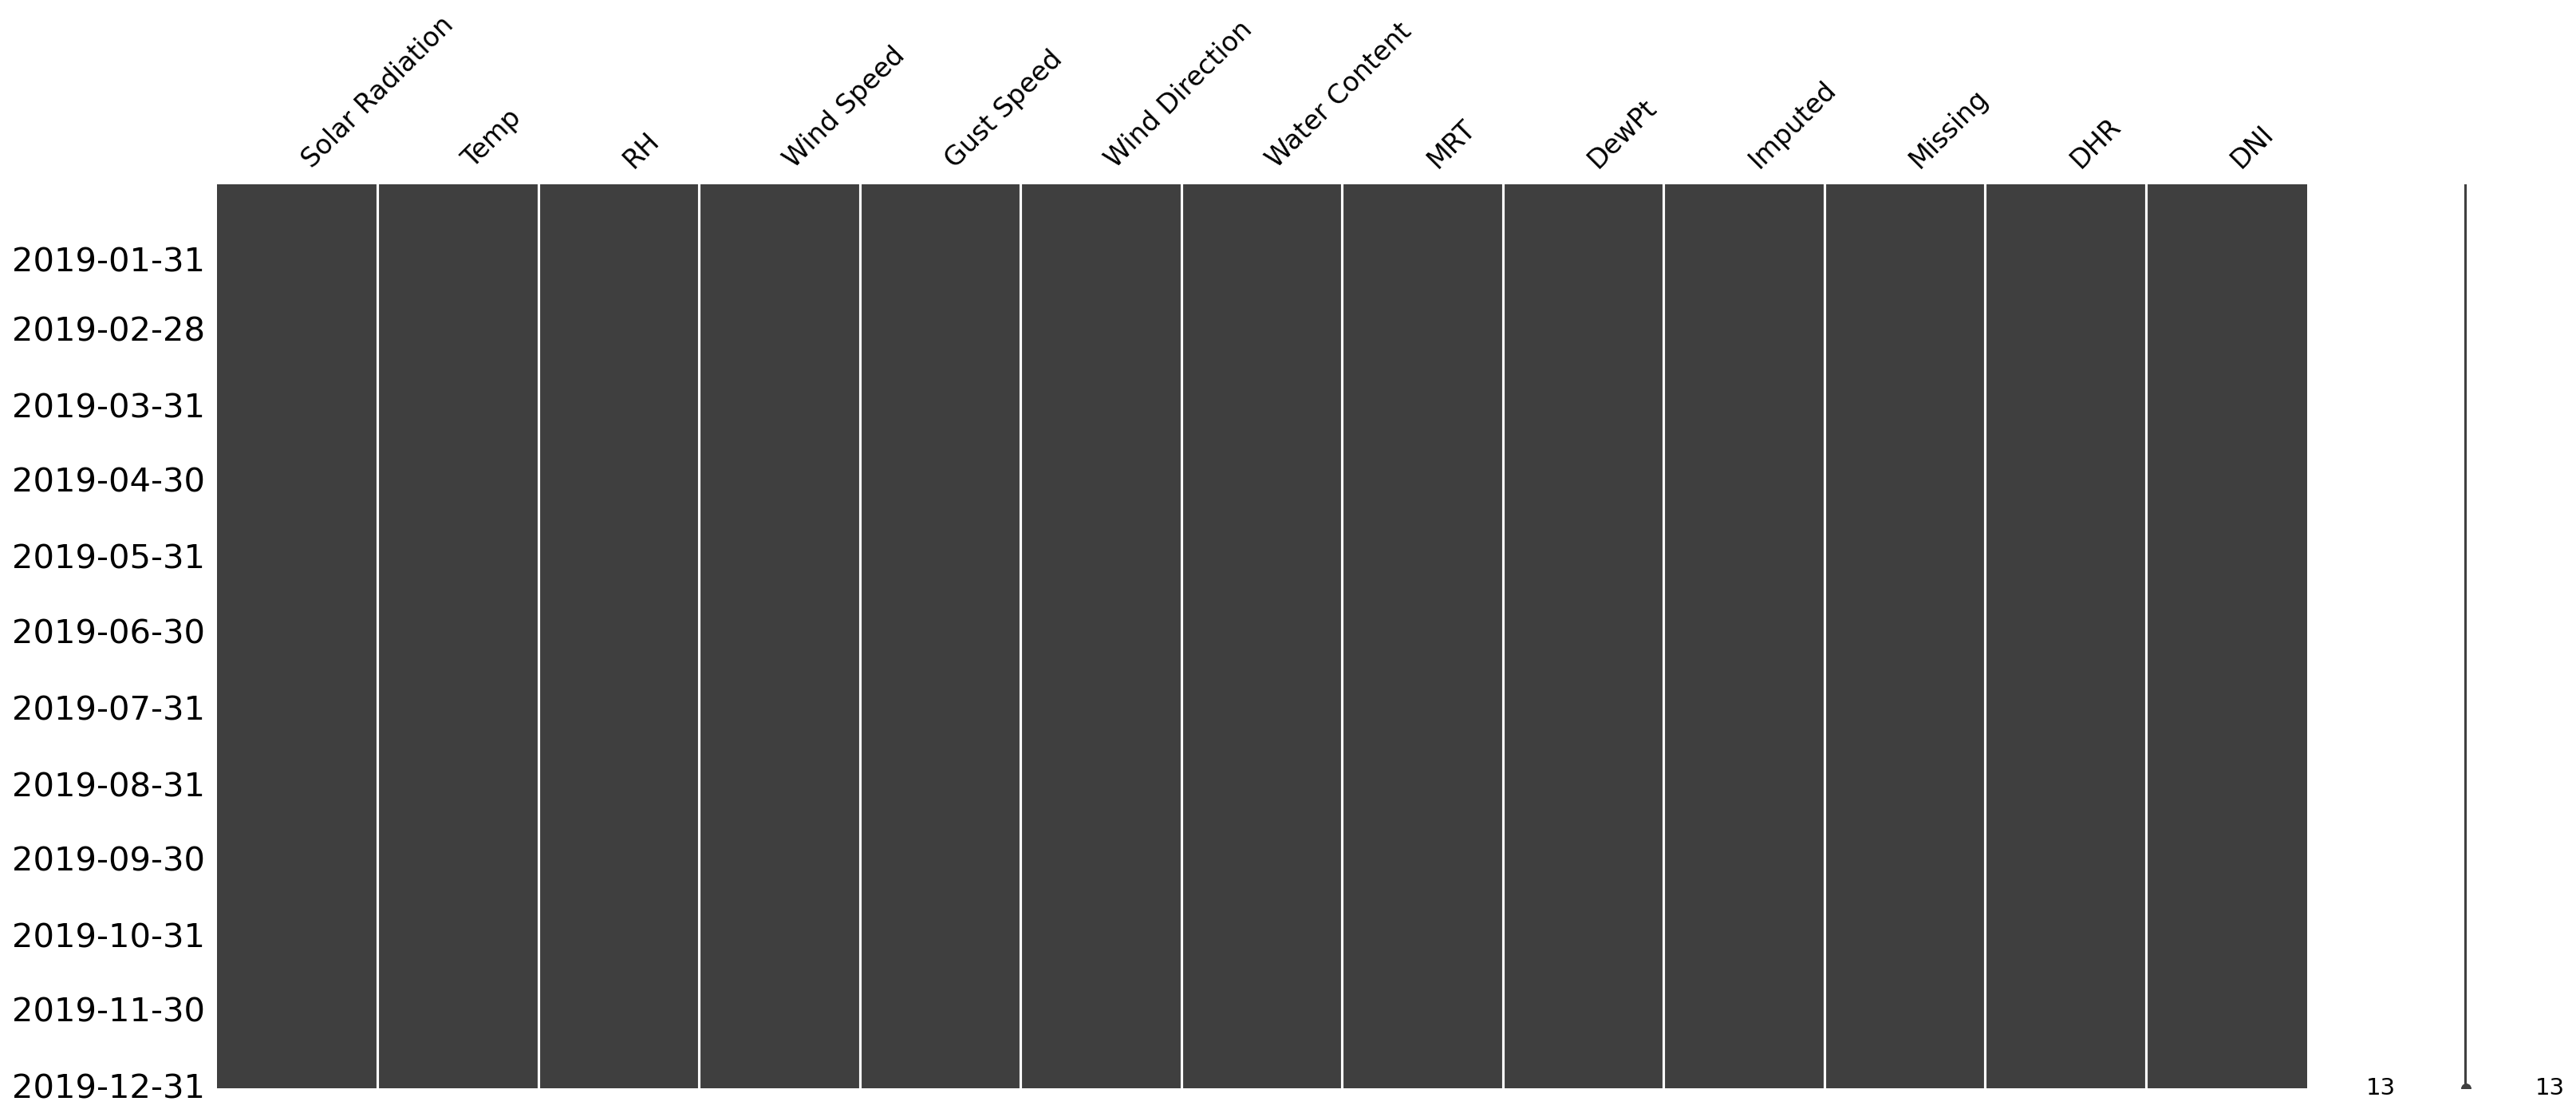

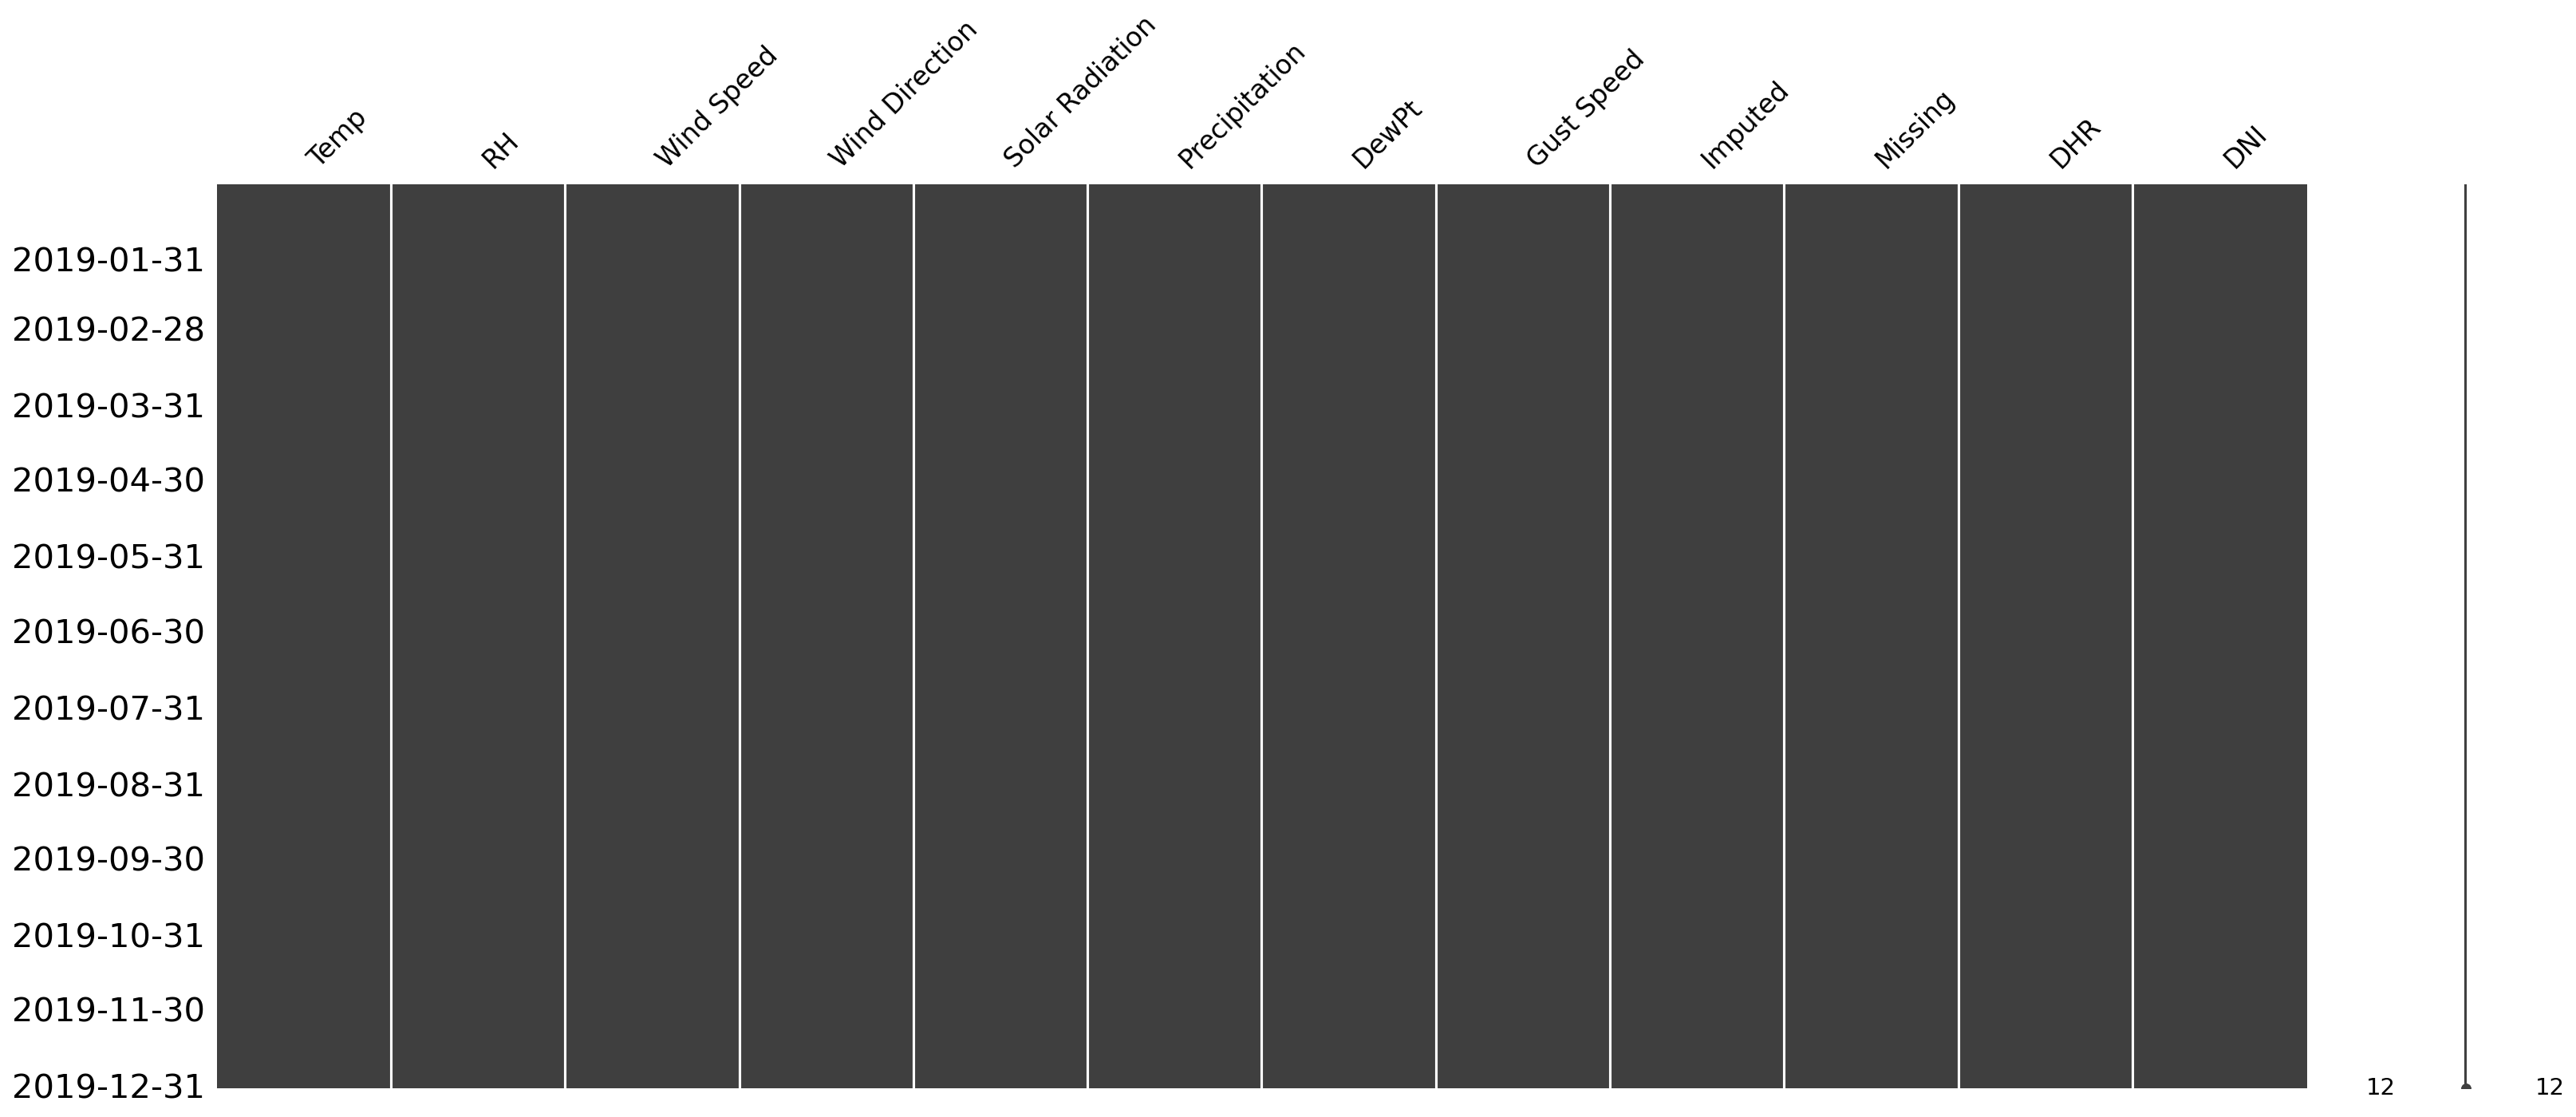

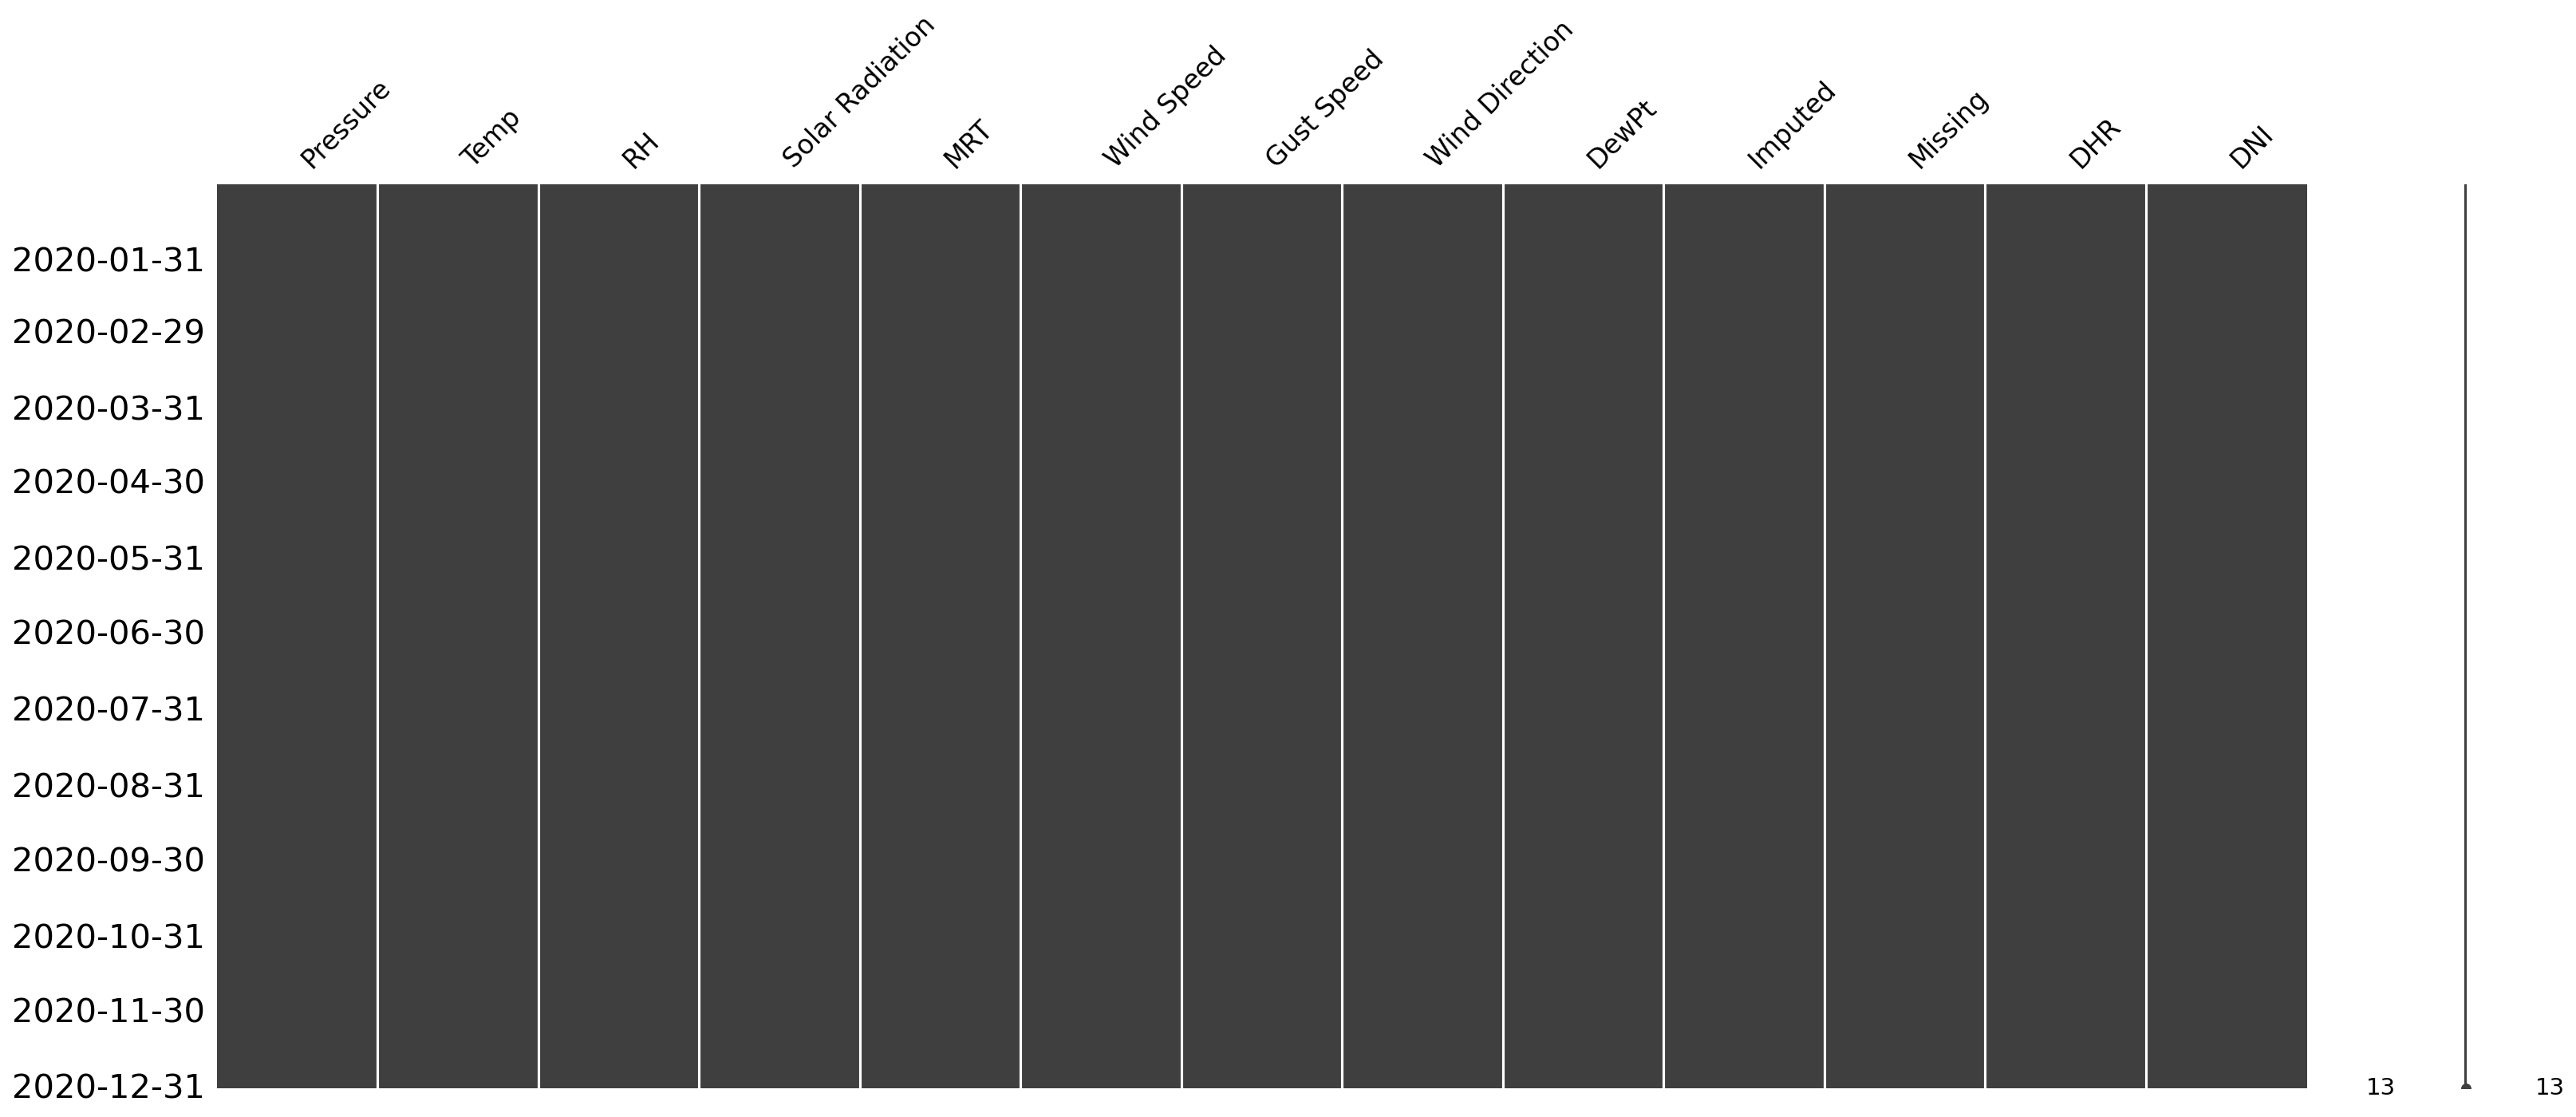

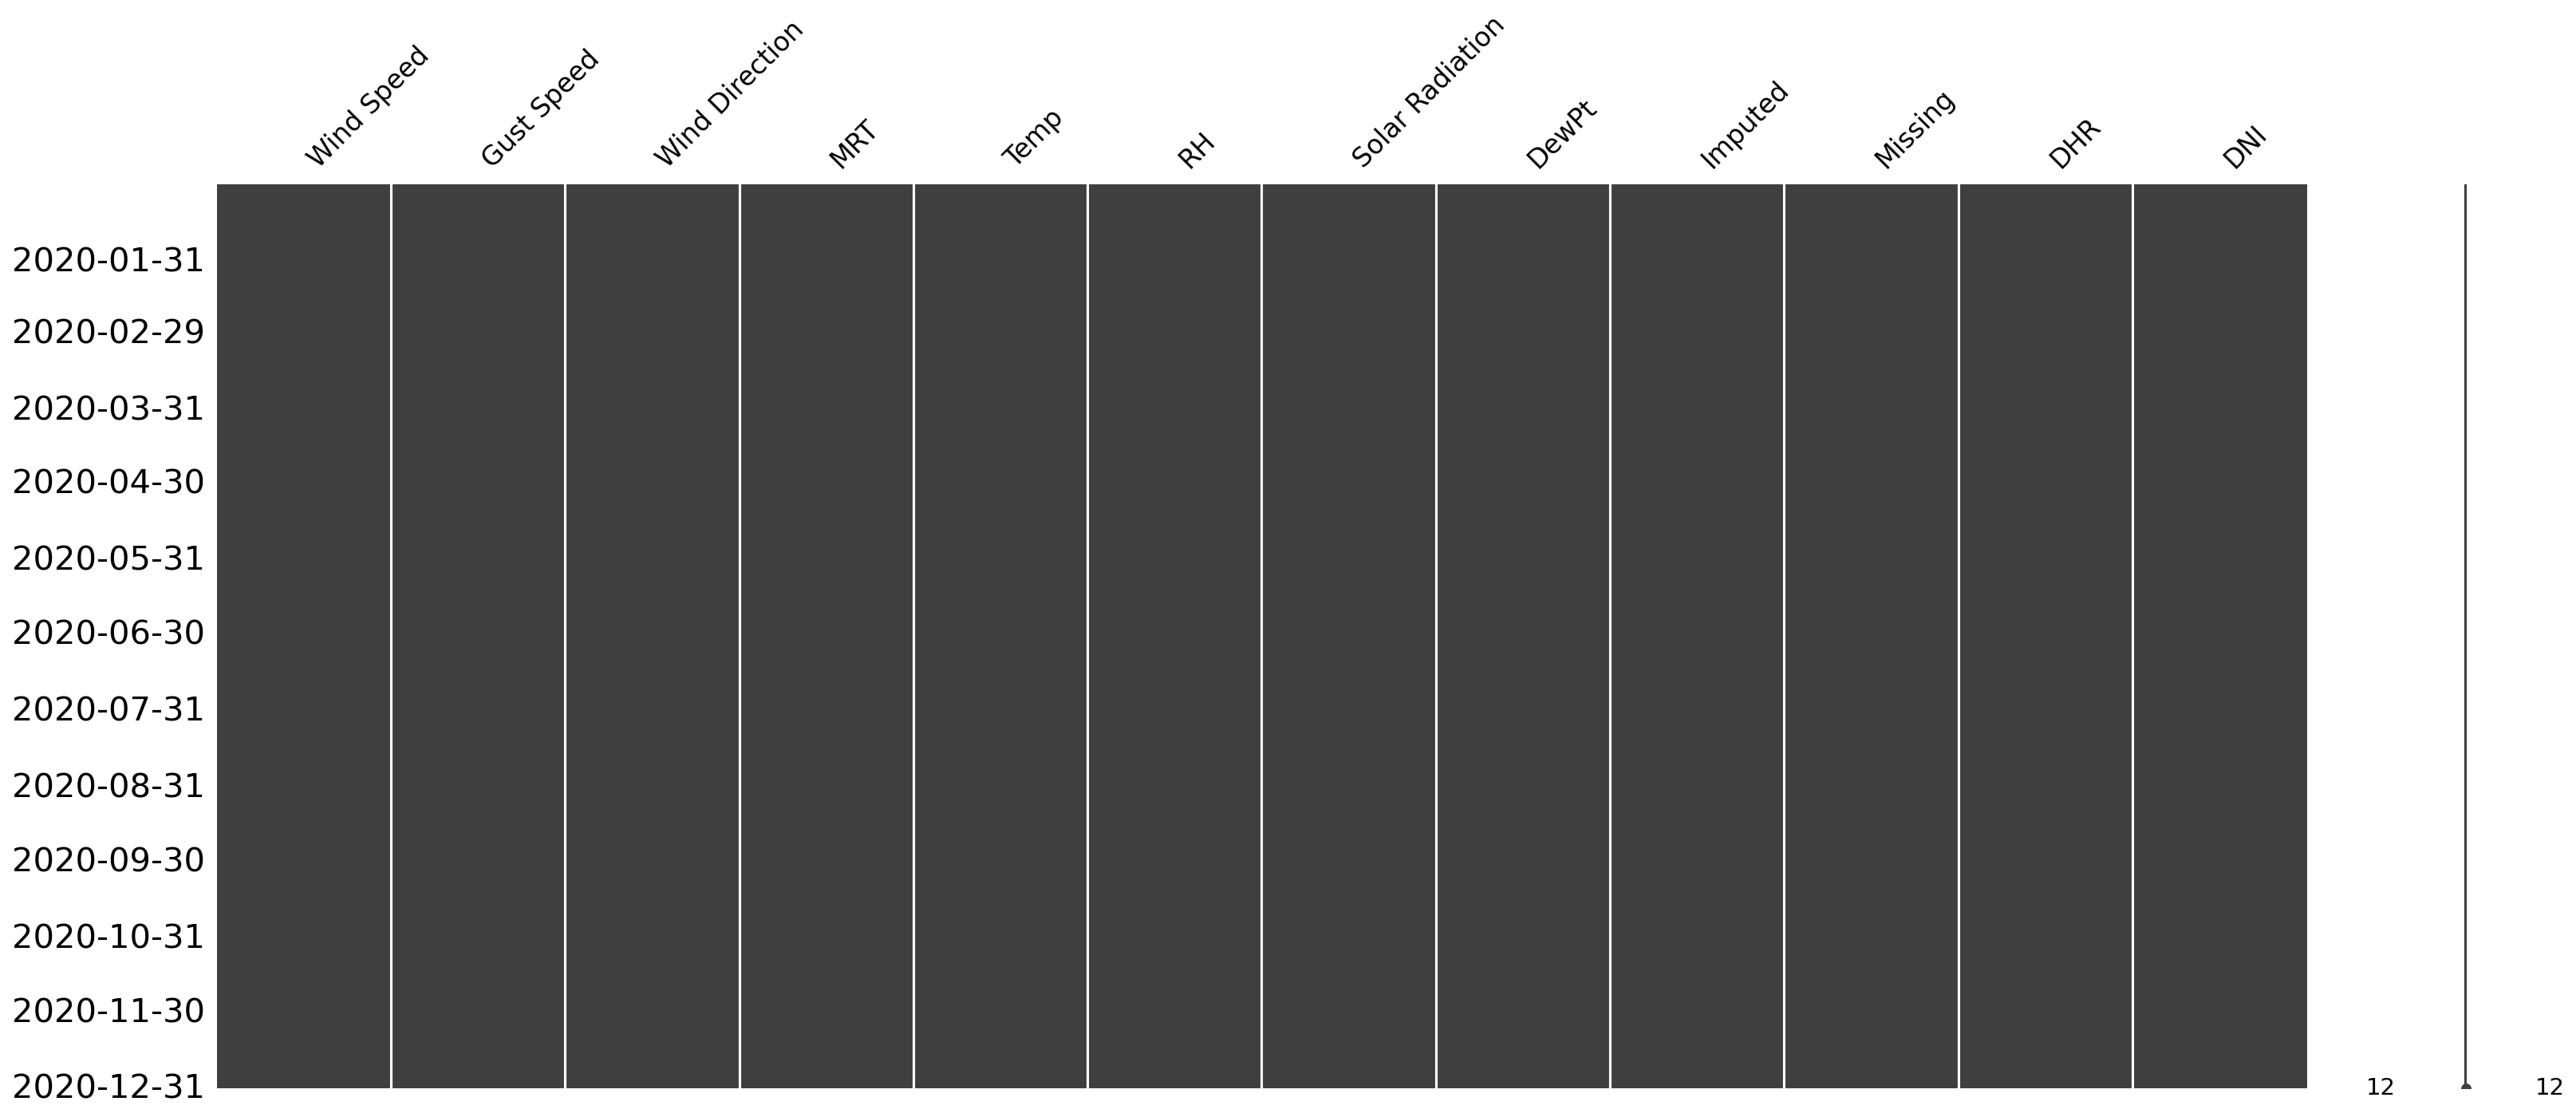

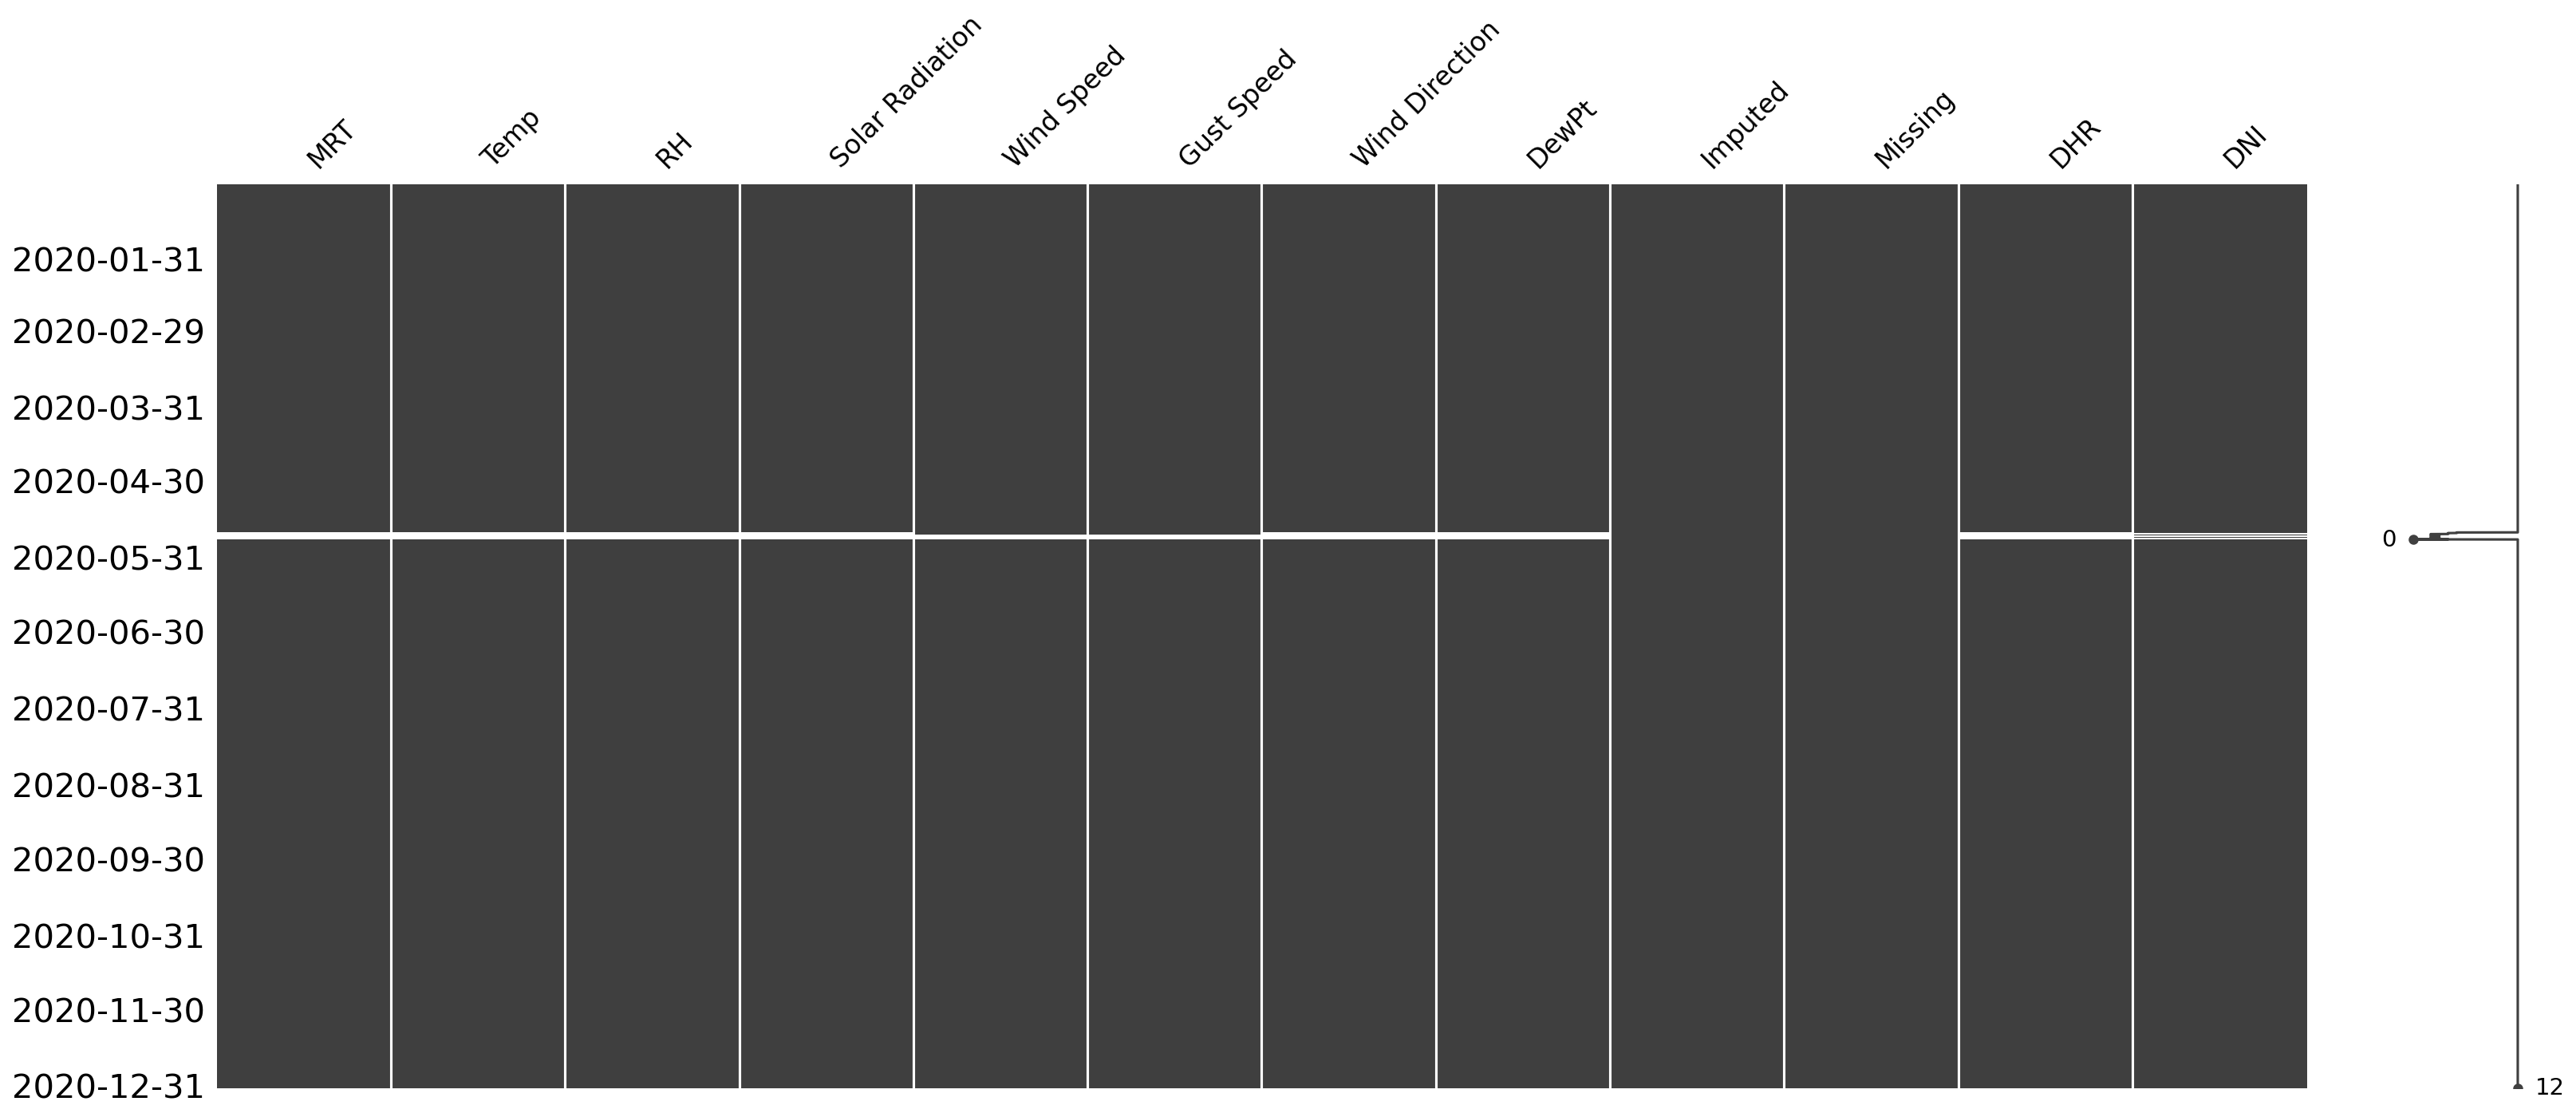

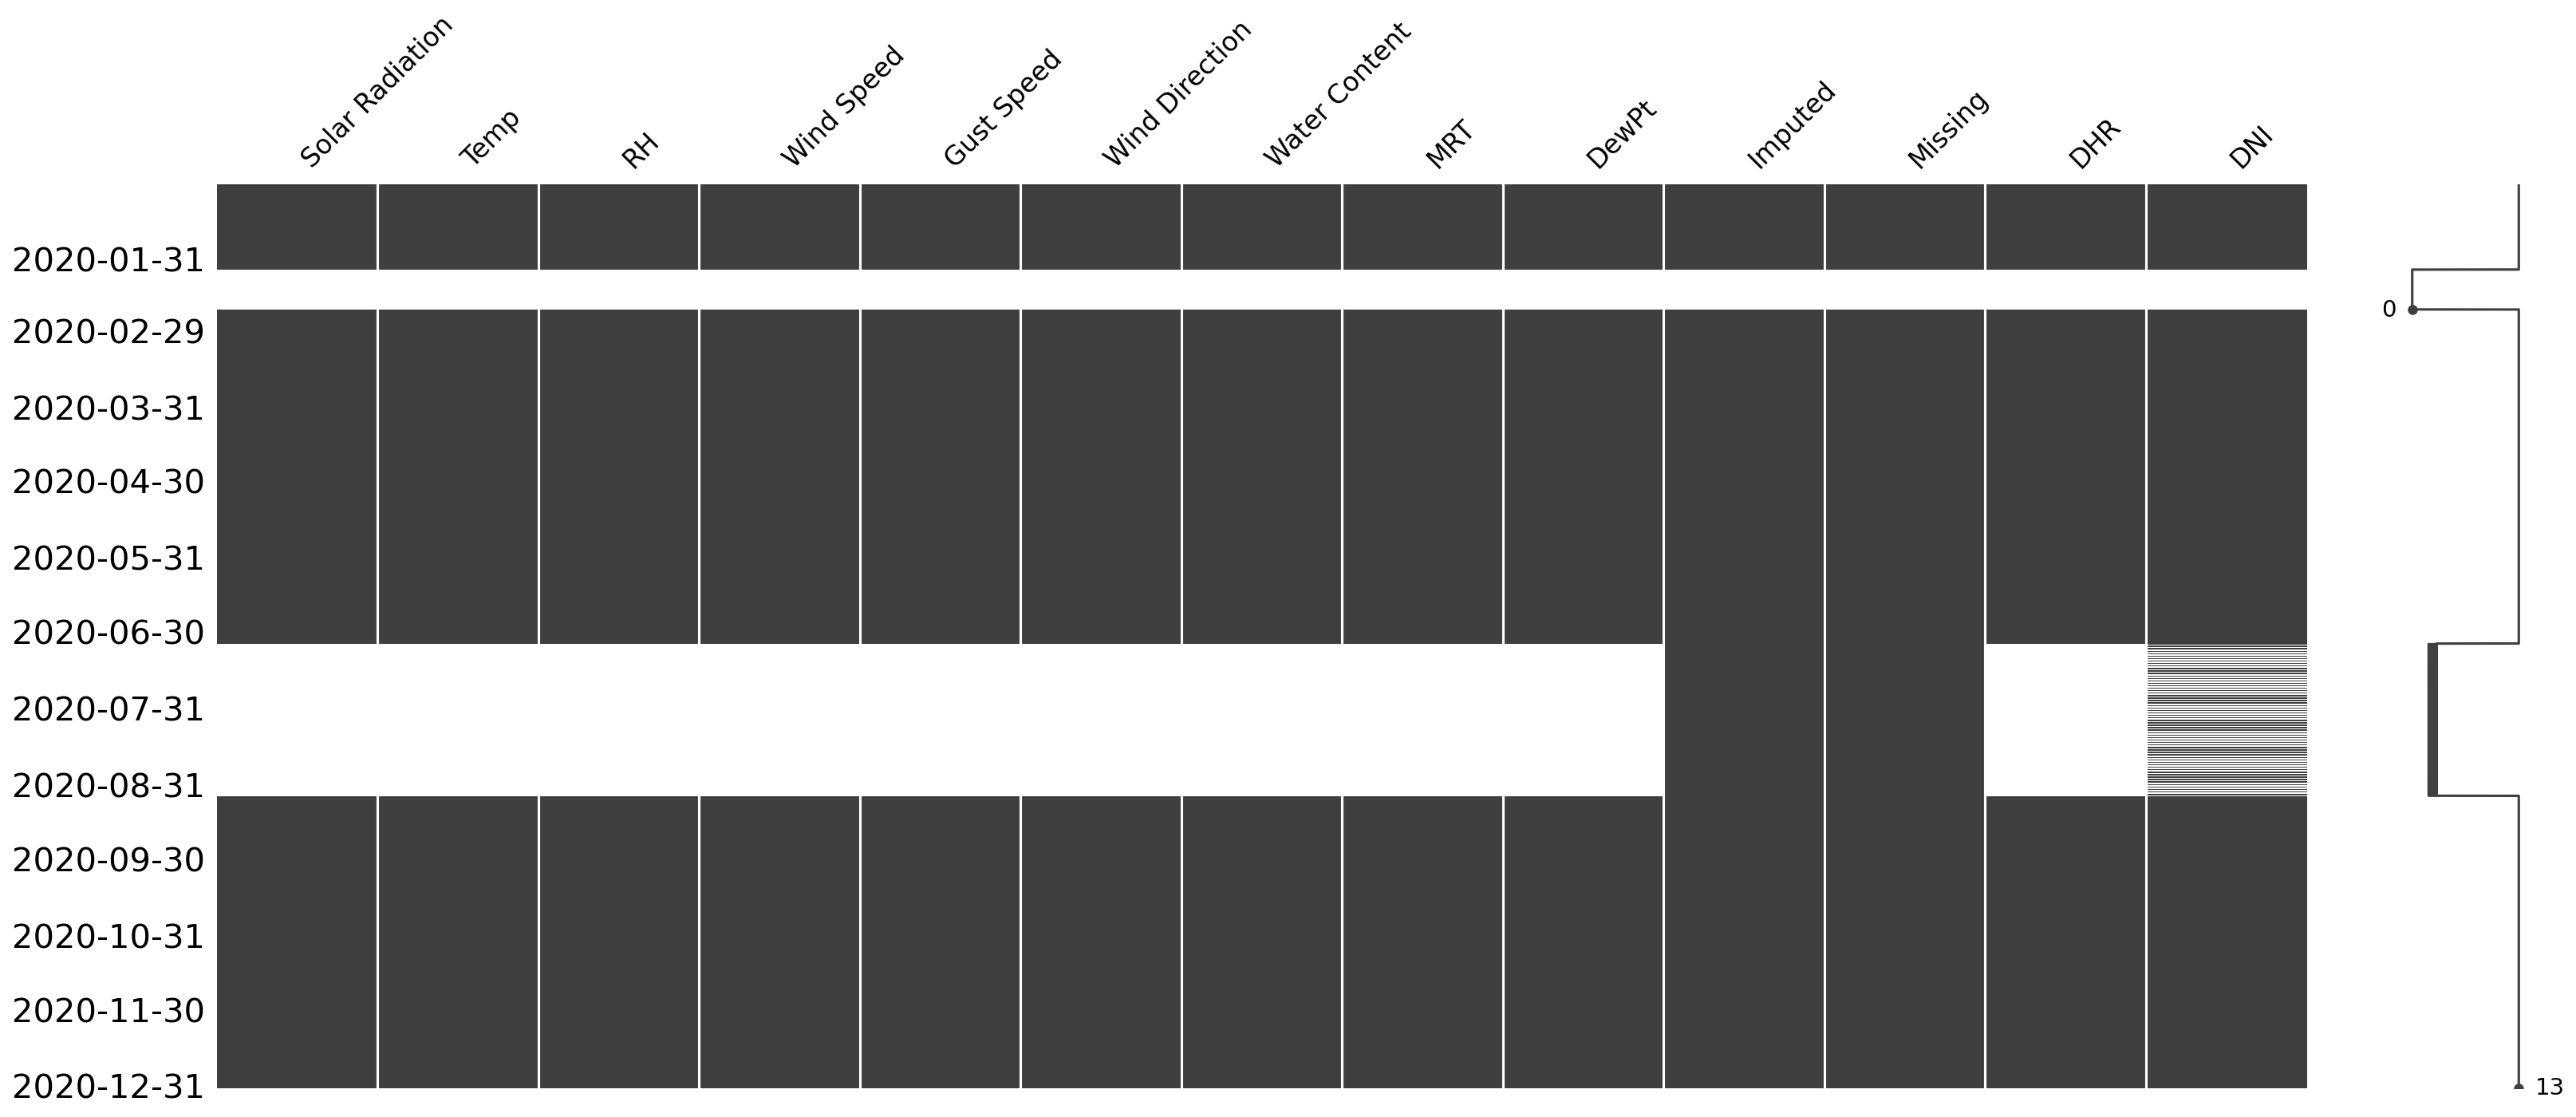

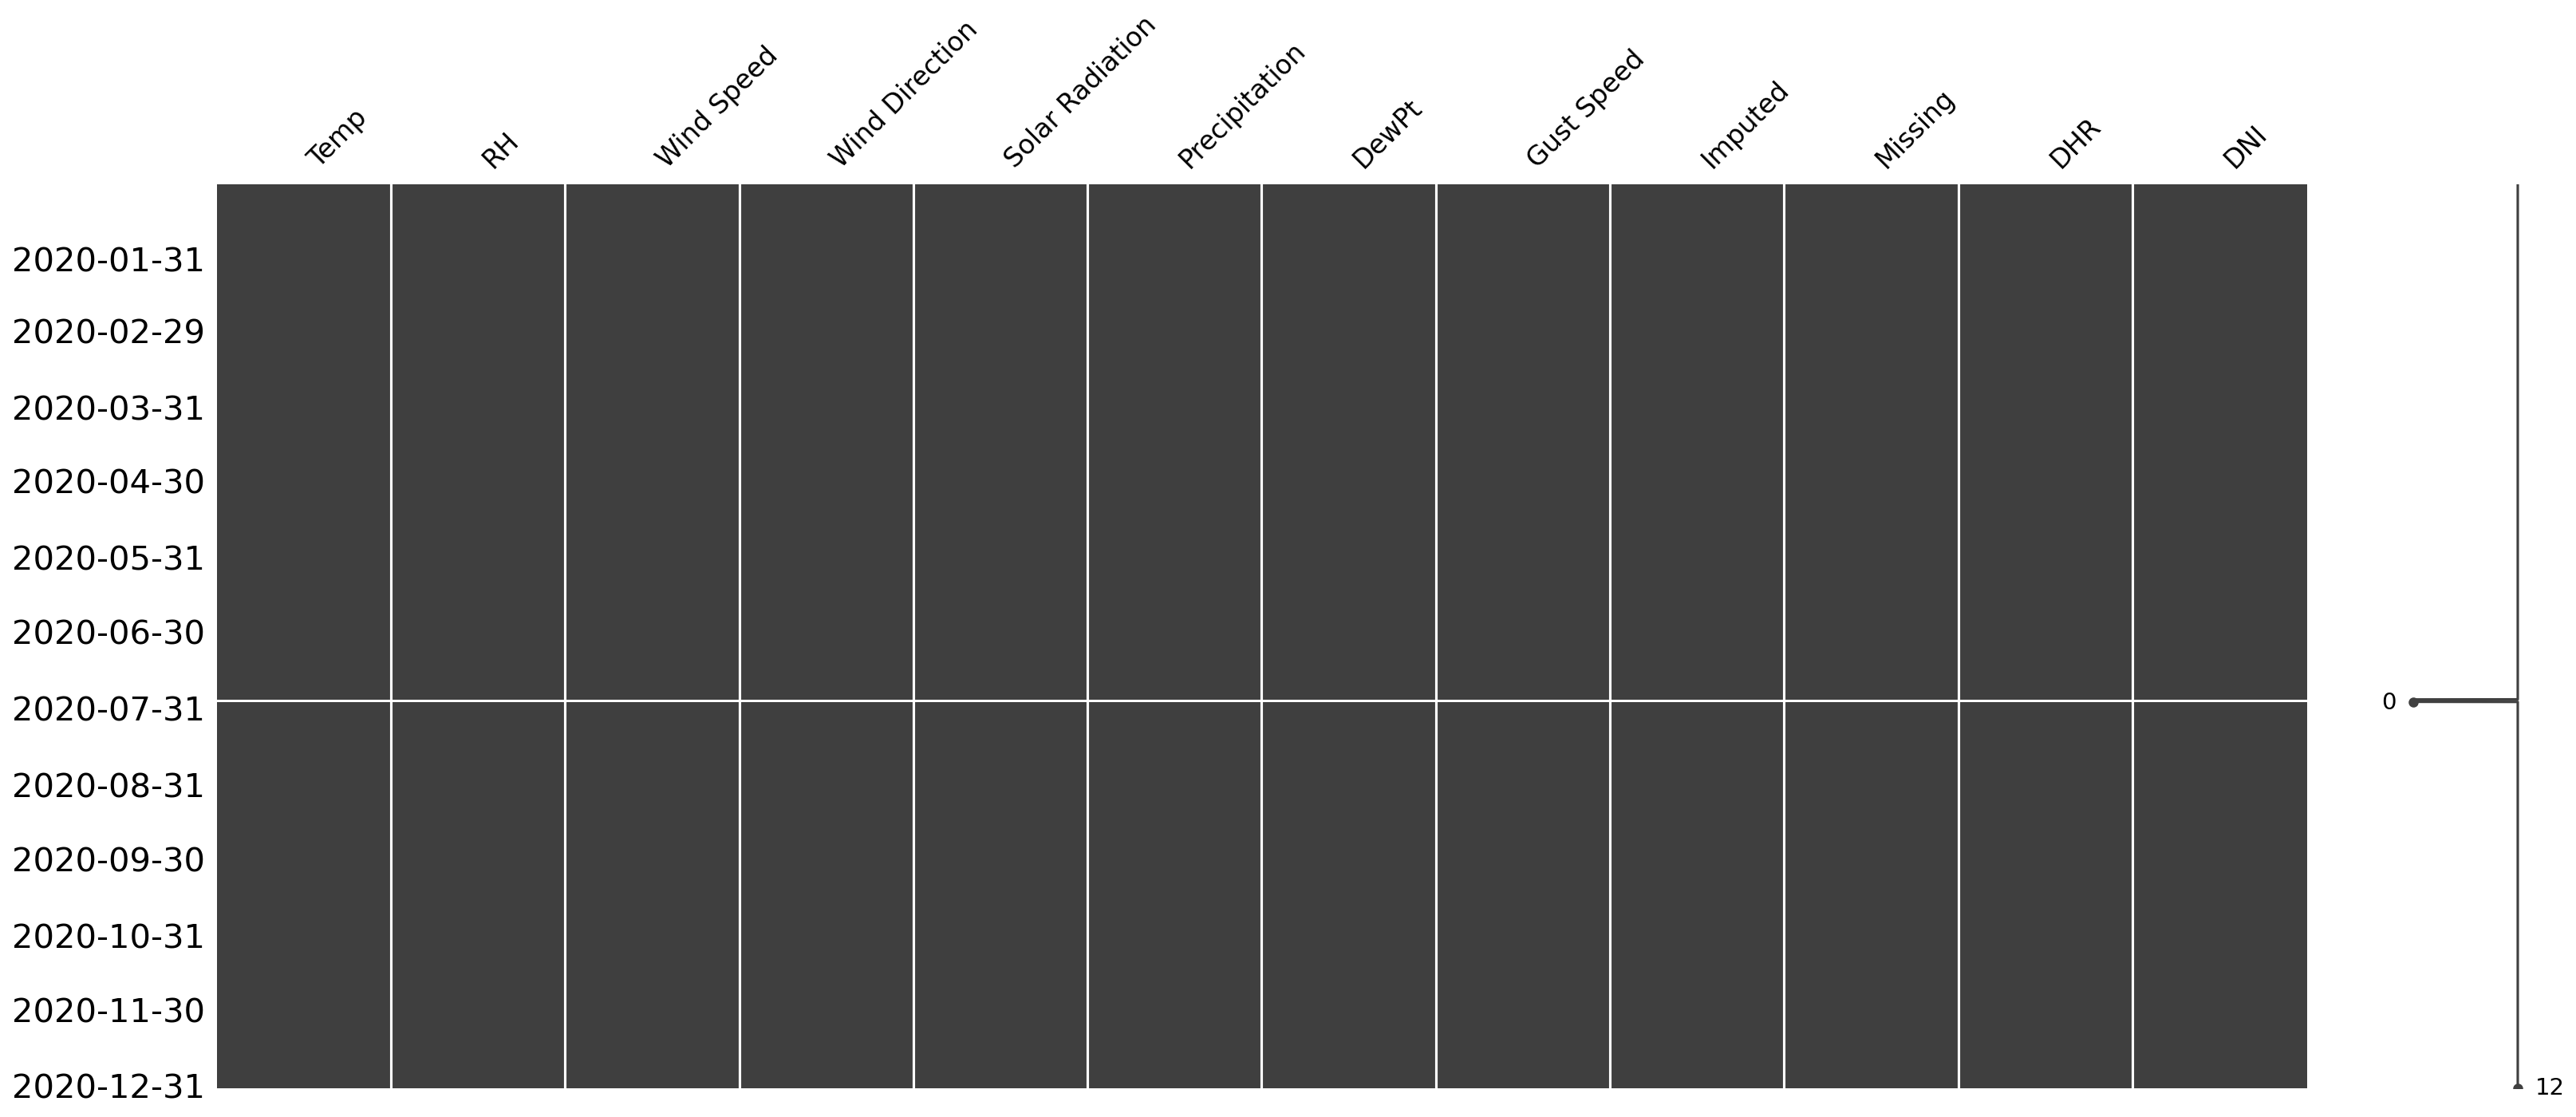

In [187]:
# All to EPW
year = [2019, 2020]

#names = ["DL1_Stone_Garden_Tjaden_Hall.csv","DL2_PSB_Parking_Lot.csv","DL3_Olin_Library.csv","DL4_Milstein_Hall_Roof.csv", "DL5_Game_Farm_Road.csv"]

stations = {'DL1': df1, 'DL2': df2, 'DL3': df3, 'DL4': df4, 'DL5': df5}

ul = list(itertools.product(year, stations))

for y, s in ul:
    print(y, s)
    make_epw(s, y, stations[s], False)

C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in calc_split (vectorized)
  outputs = ufunc(*inputs)


Leap year day removed.
Leap year day removed.
Leap year day removed.
Leap year day removed.
Leap year day removed.


,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2020,1,1,1,0,999.0,-0.490000,-6.030000,72.27,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
1,2020,1,1,2,0,999.0,-0.690000,-6.070000,73.12,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
2,2020,1,1,3,0,999.0,-0.840000,-5.460000,76.88,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
3,2020,1,1,4,0,999.0,-0.970000,-5.320000,78.23,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
4,2020,1,1,5,0,999.0,-1.220000,-4.840000,81.90,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020,12,31,20,0,999.0,-0.444444,-6.800444,68.22,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8780,2020,12,31,21,0,999.0,-0.583333,-6.259333,71.62,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8781,2020,12,31,22,0,999.0,-0.483333,-6.509333,69.87,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
8782,2020,12,31,23,0,999.0,-0.466667,-7.010667,67.28,999.0,...,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0


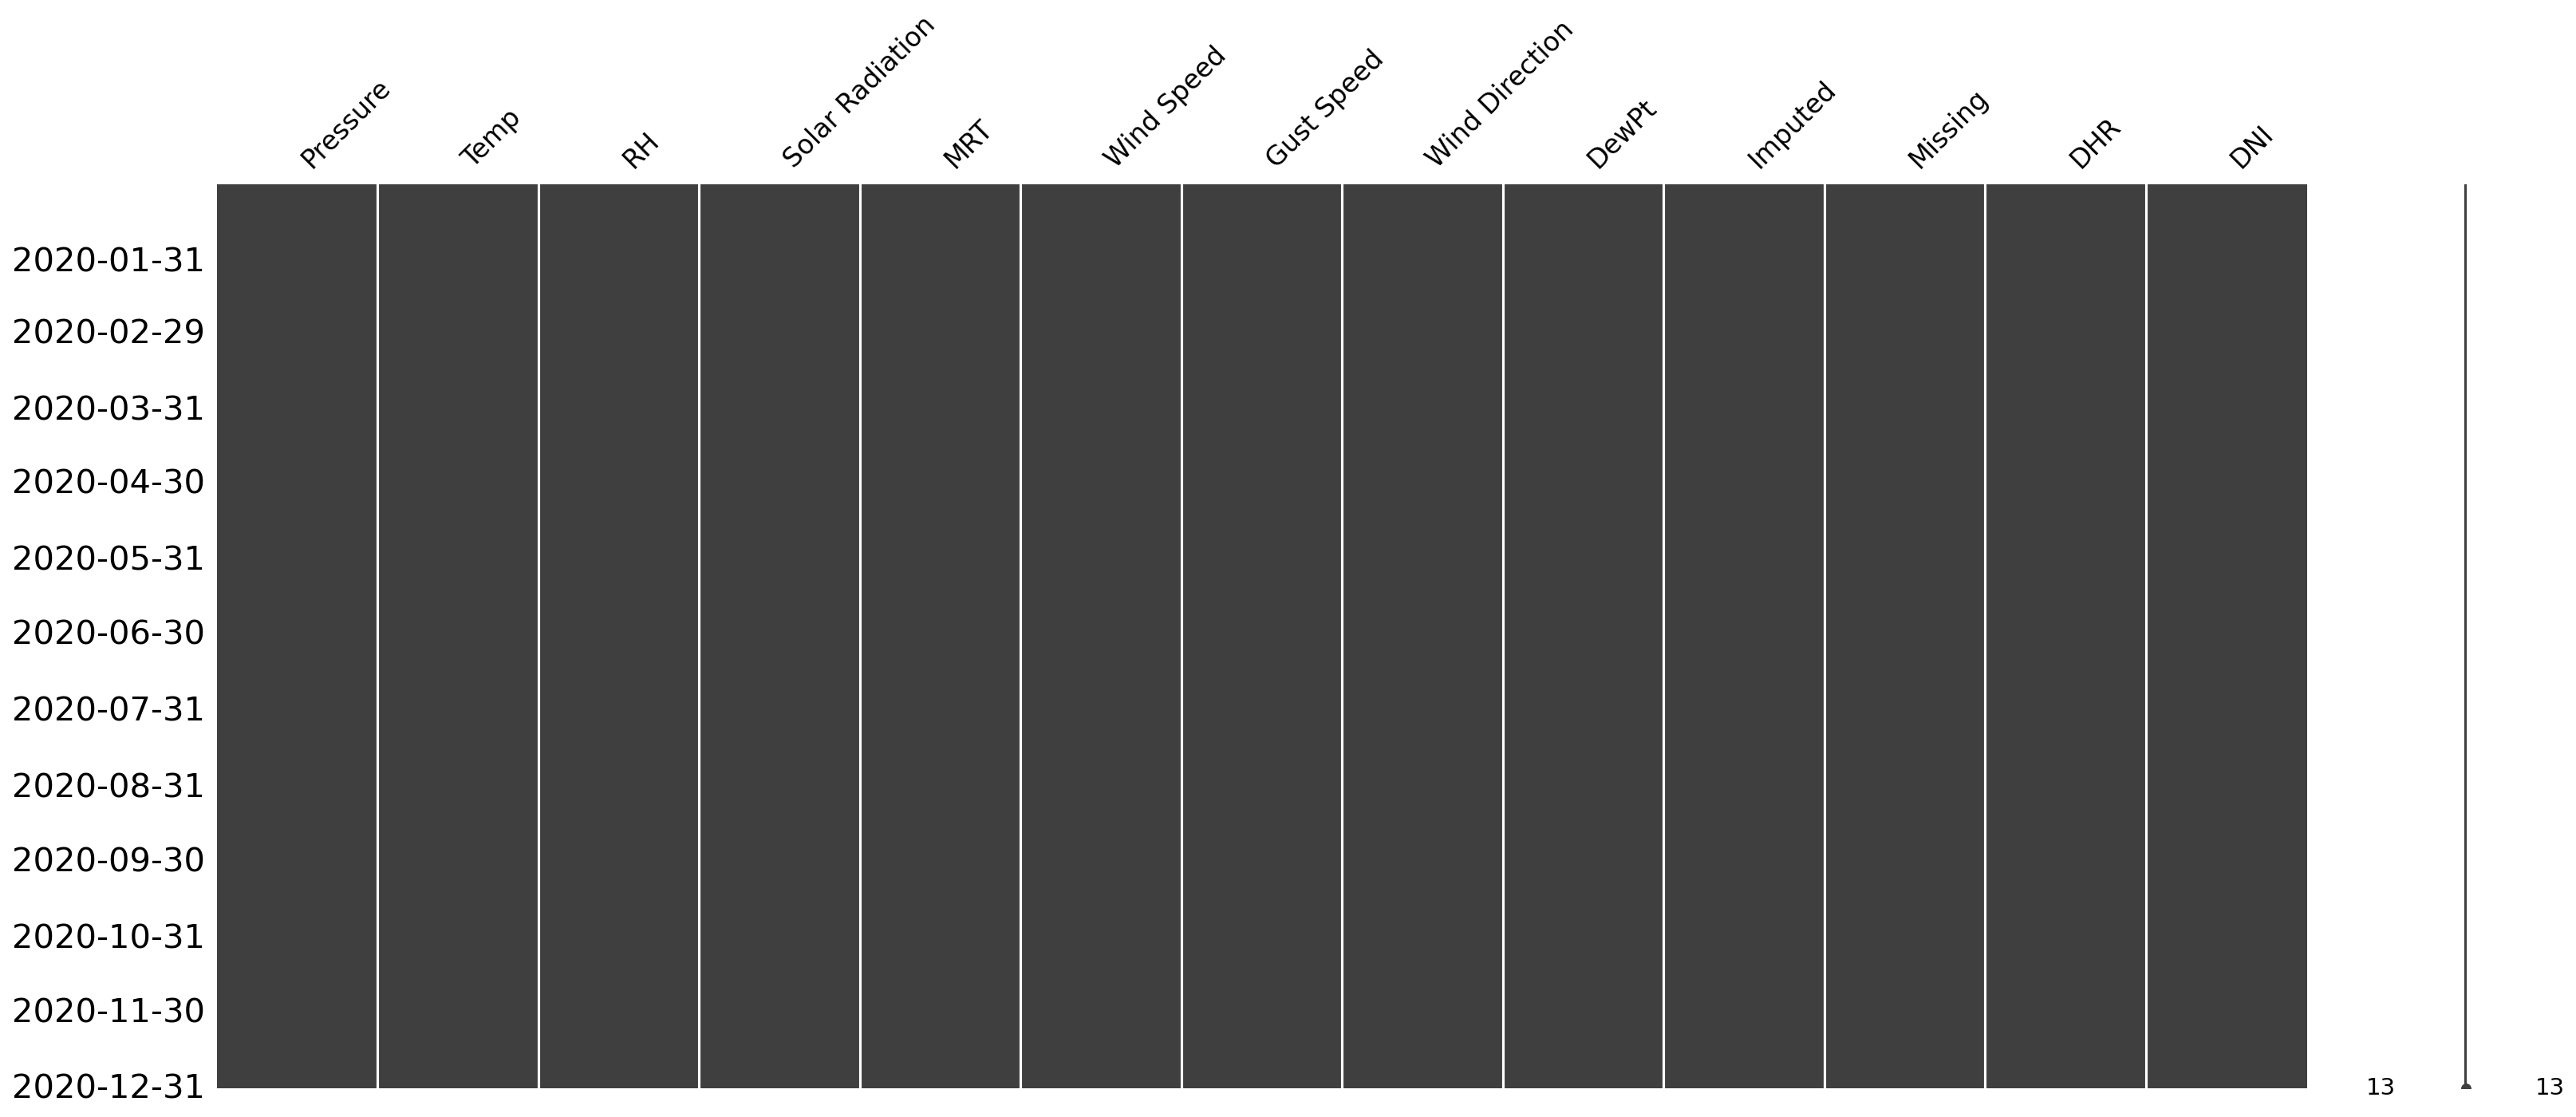

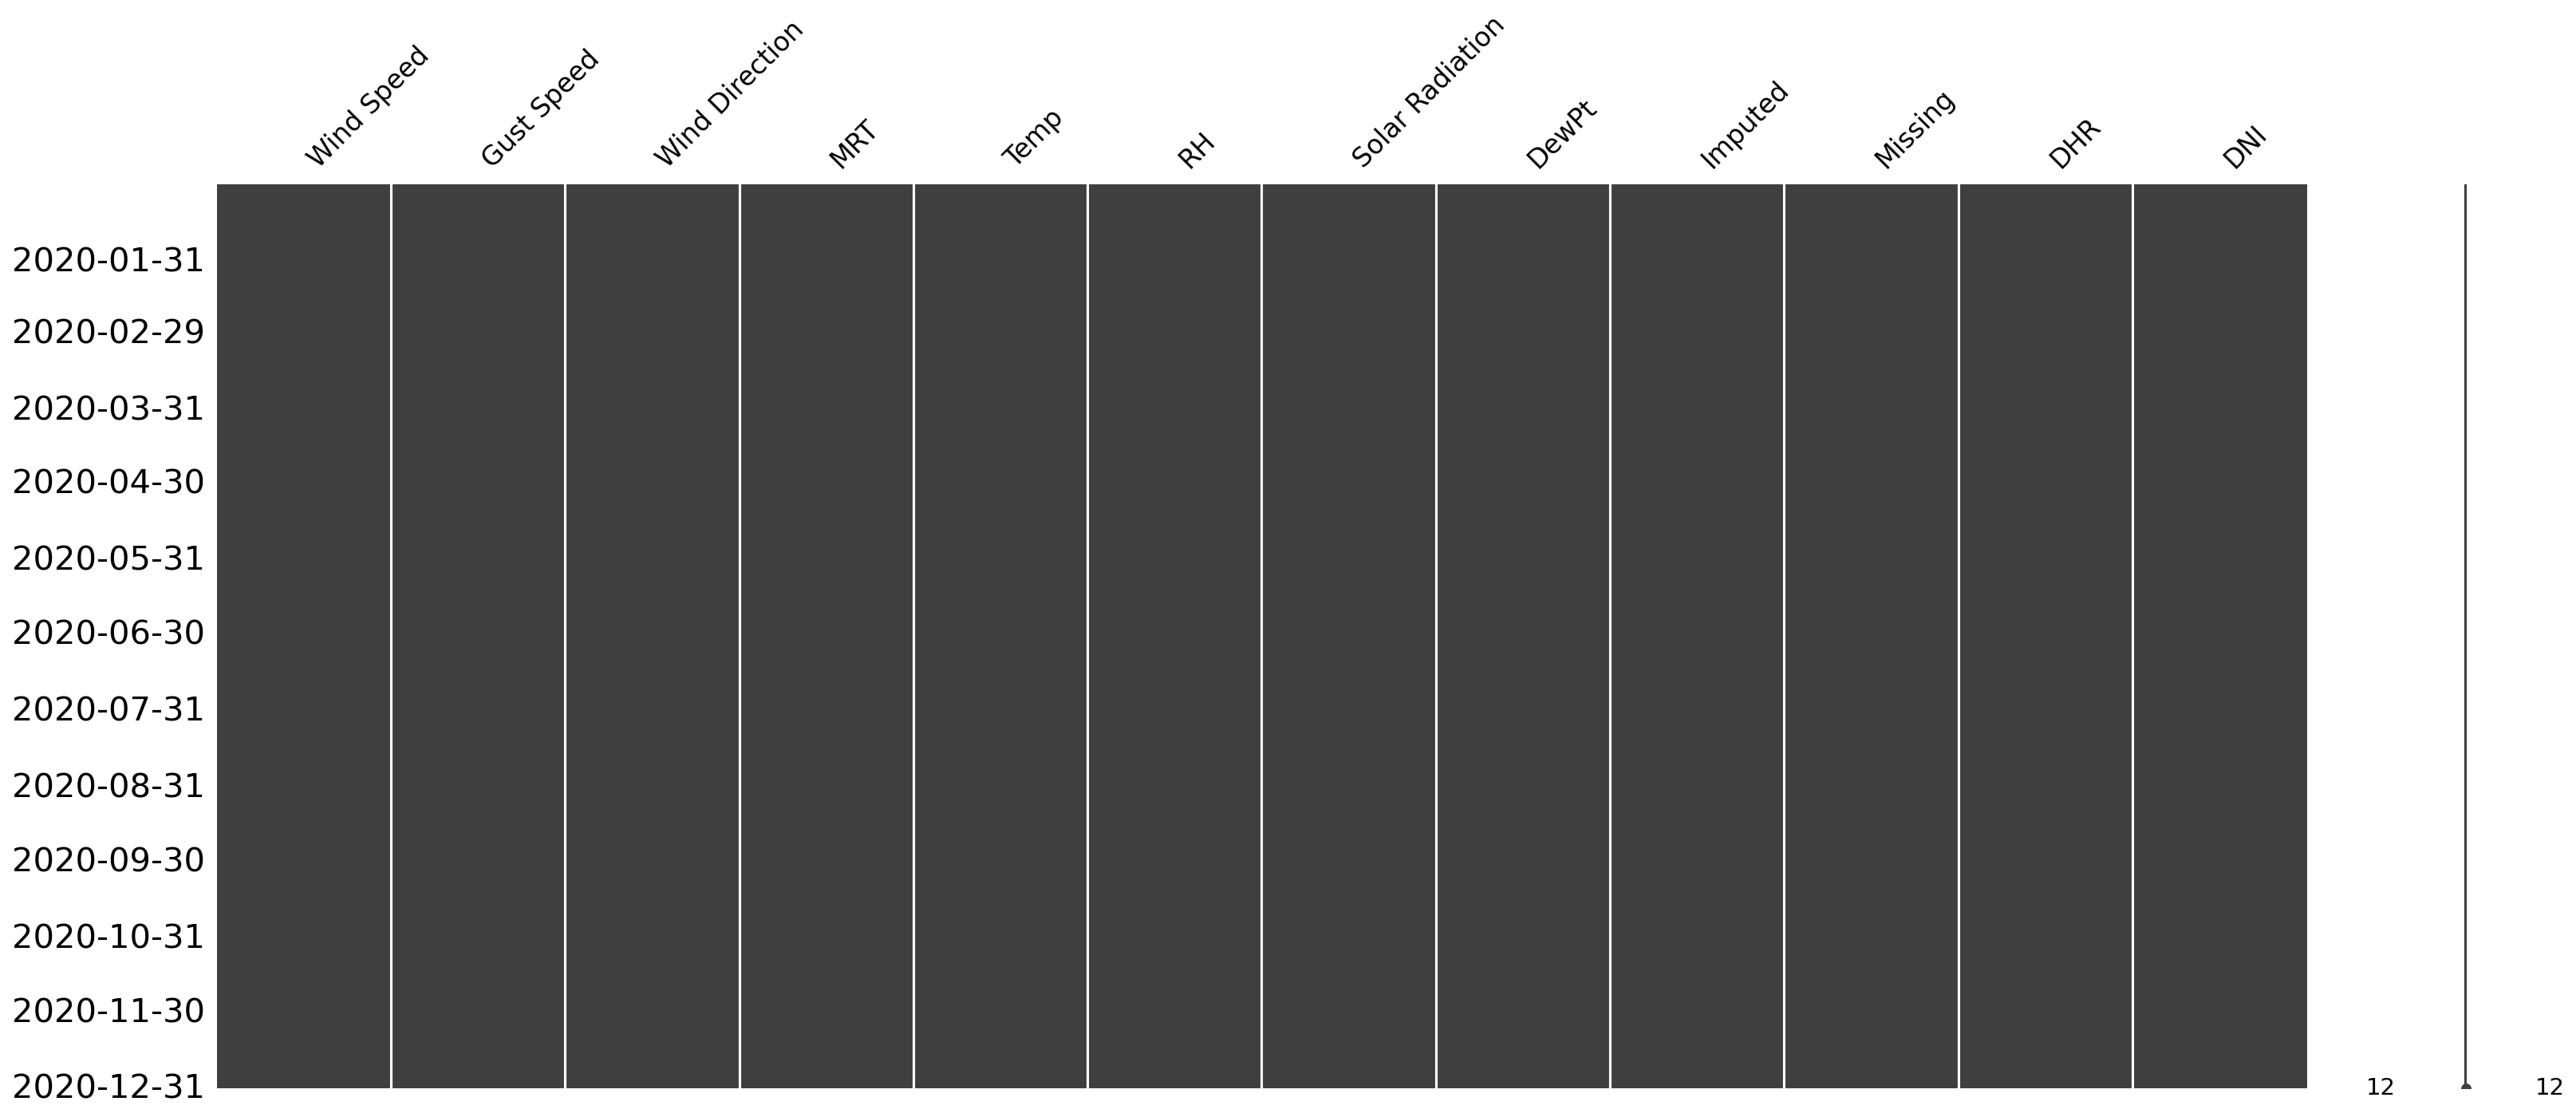

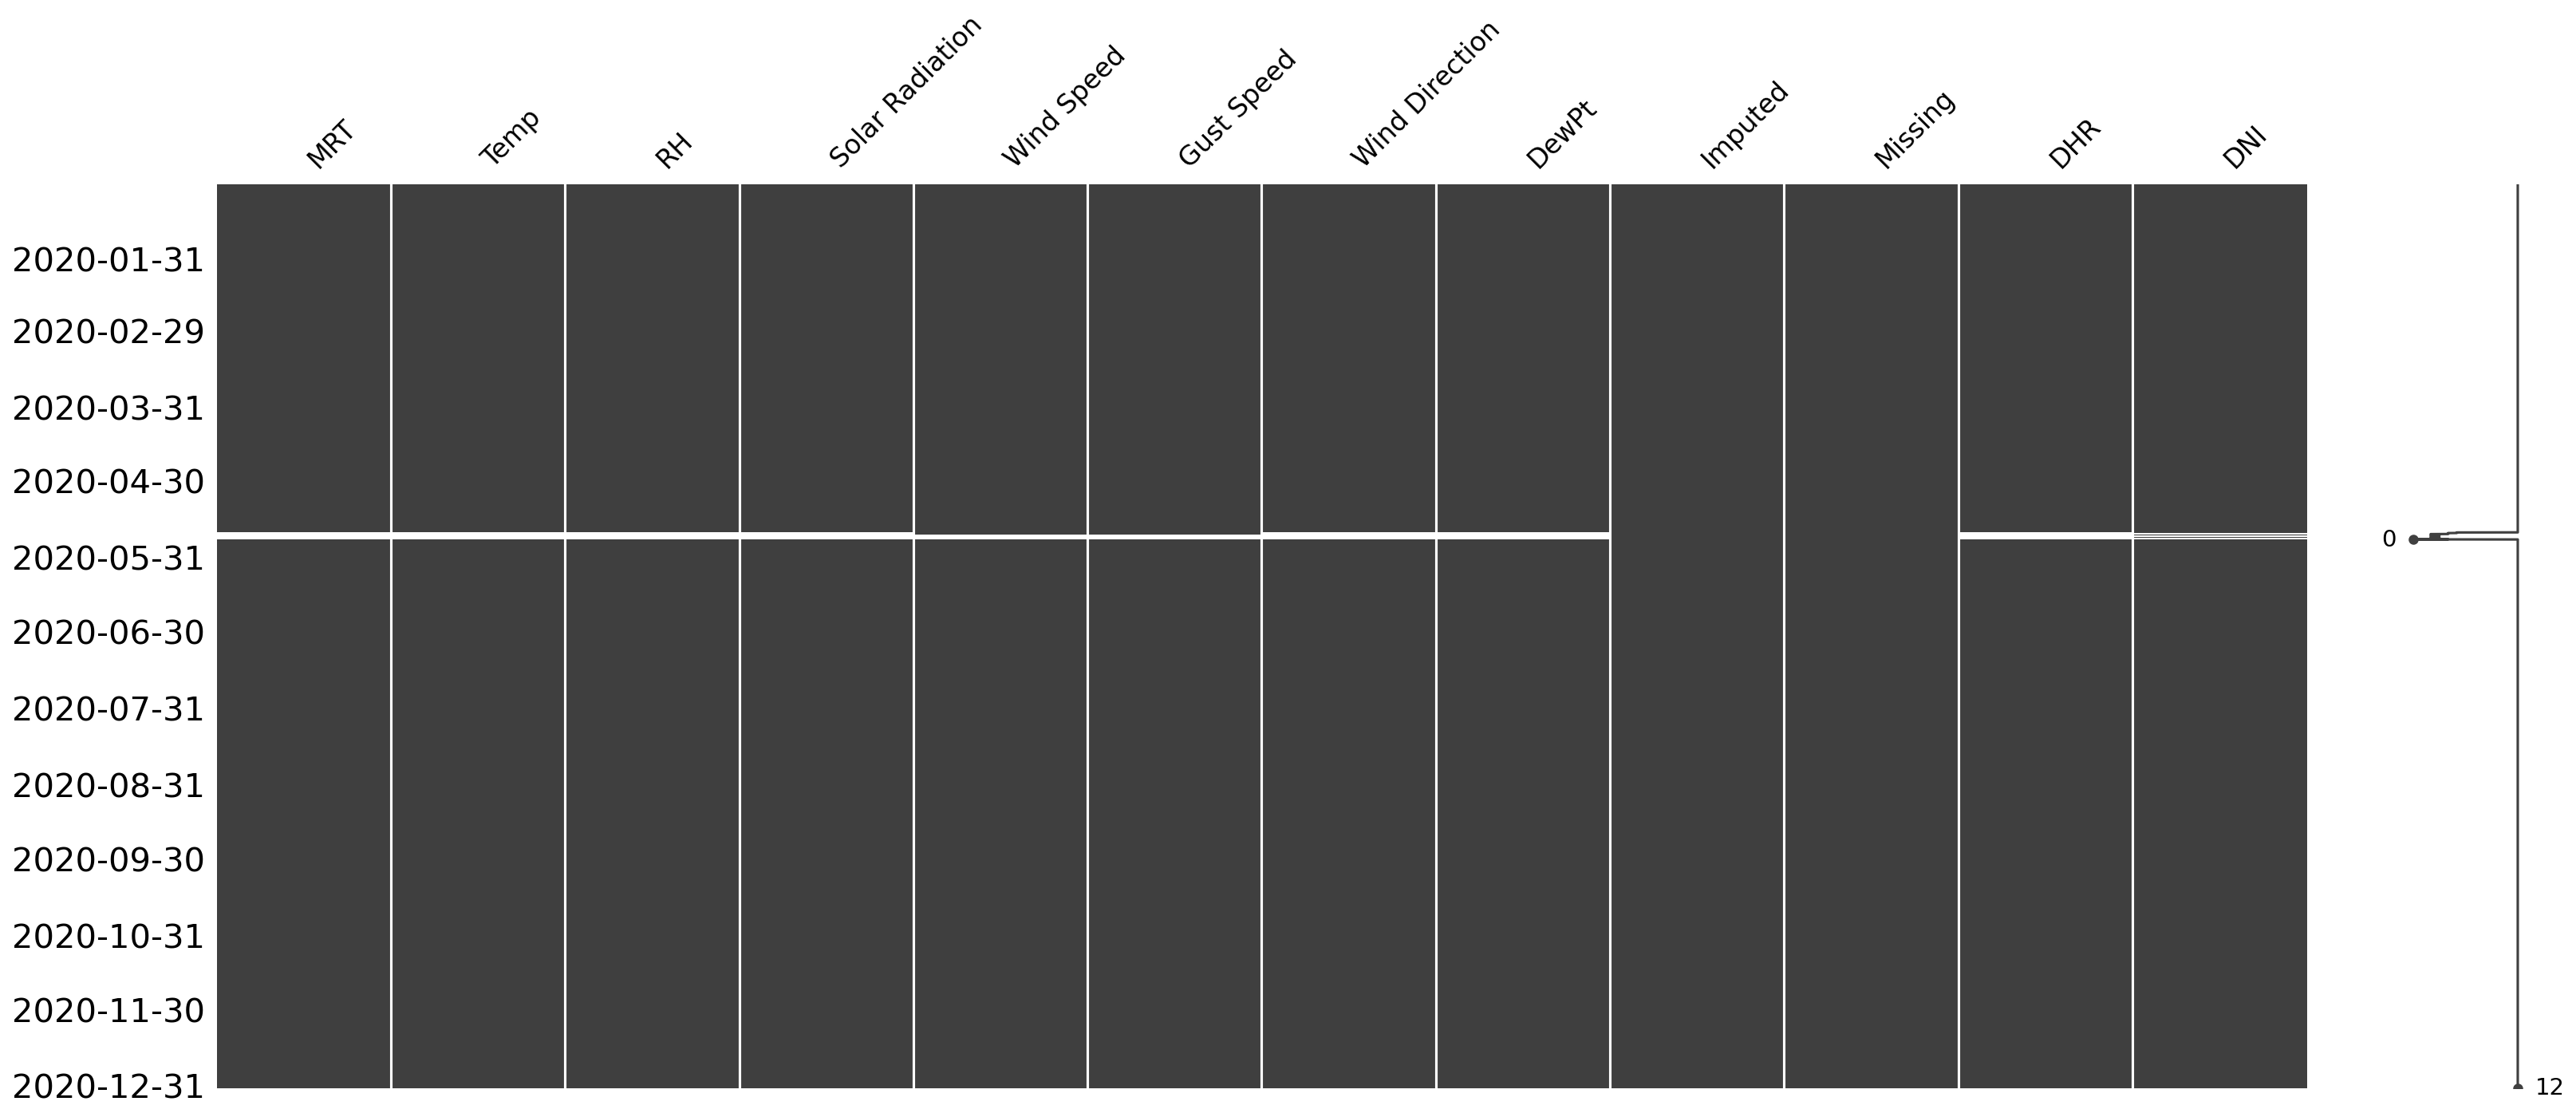

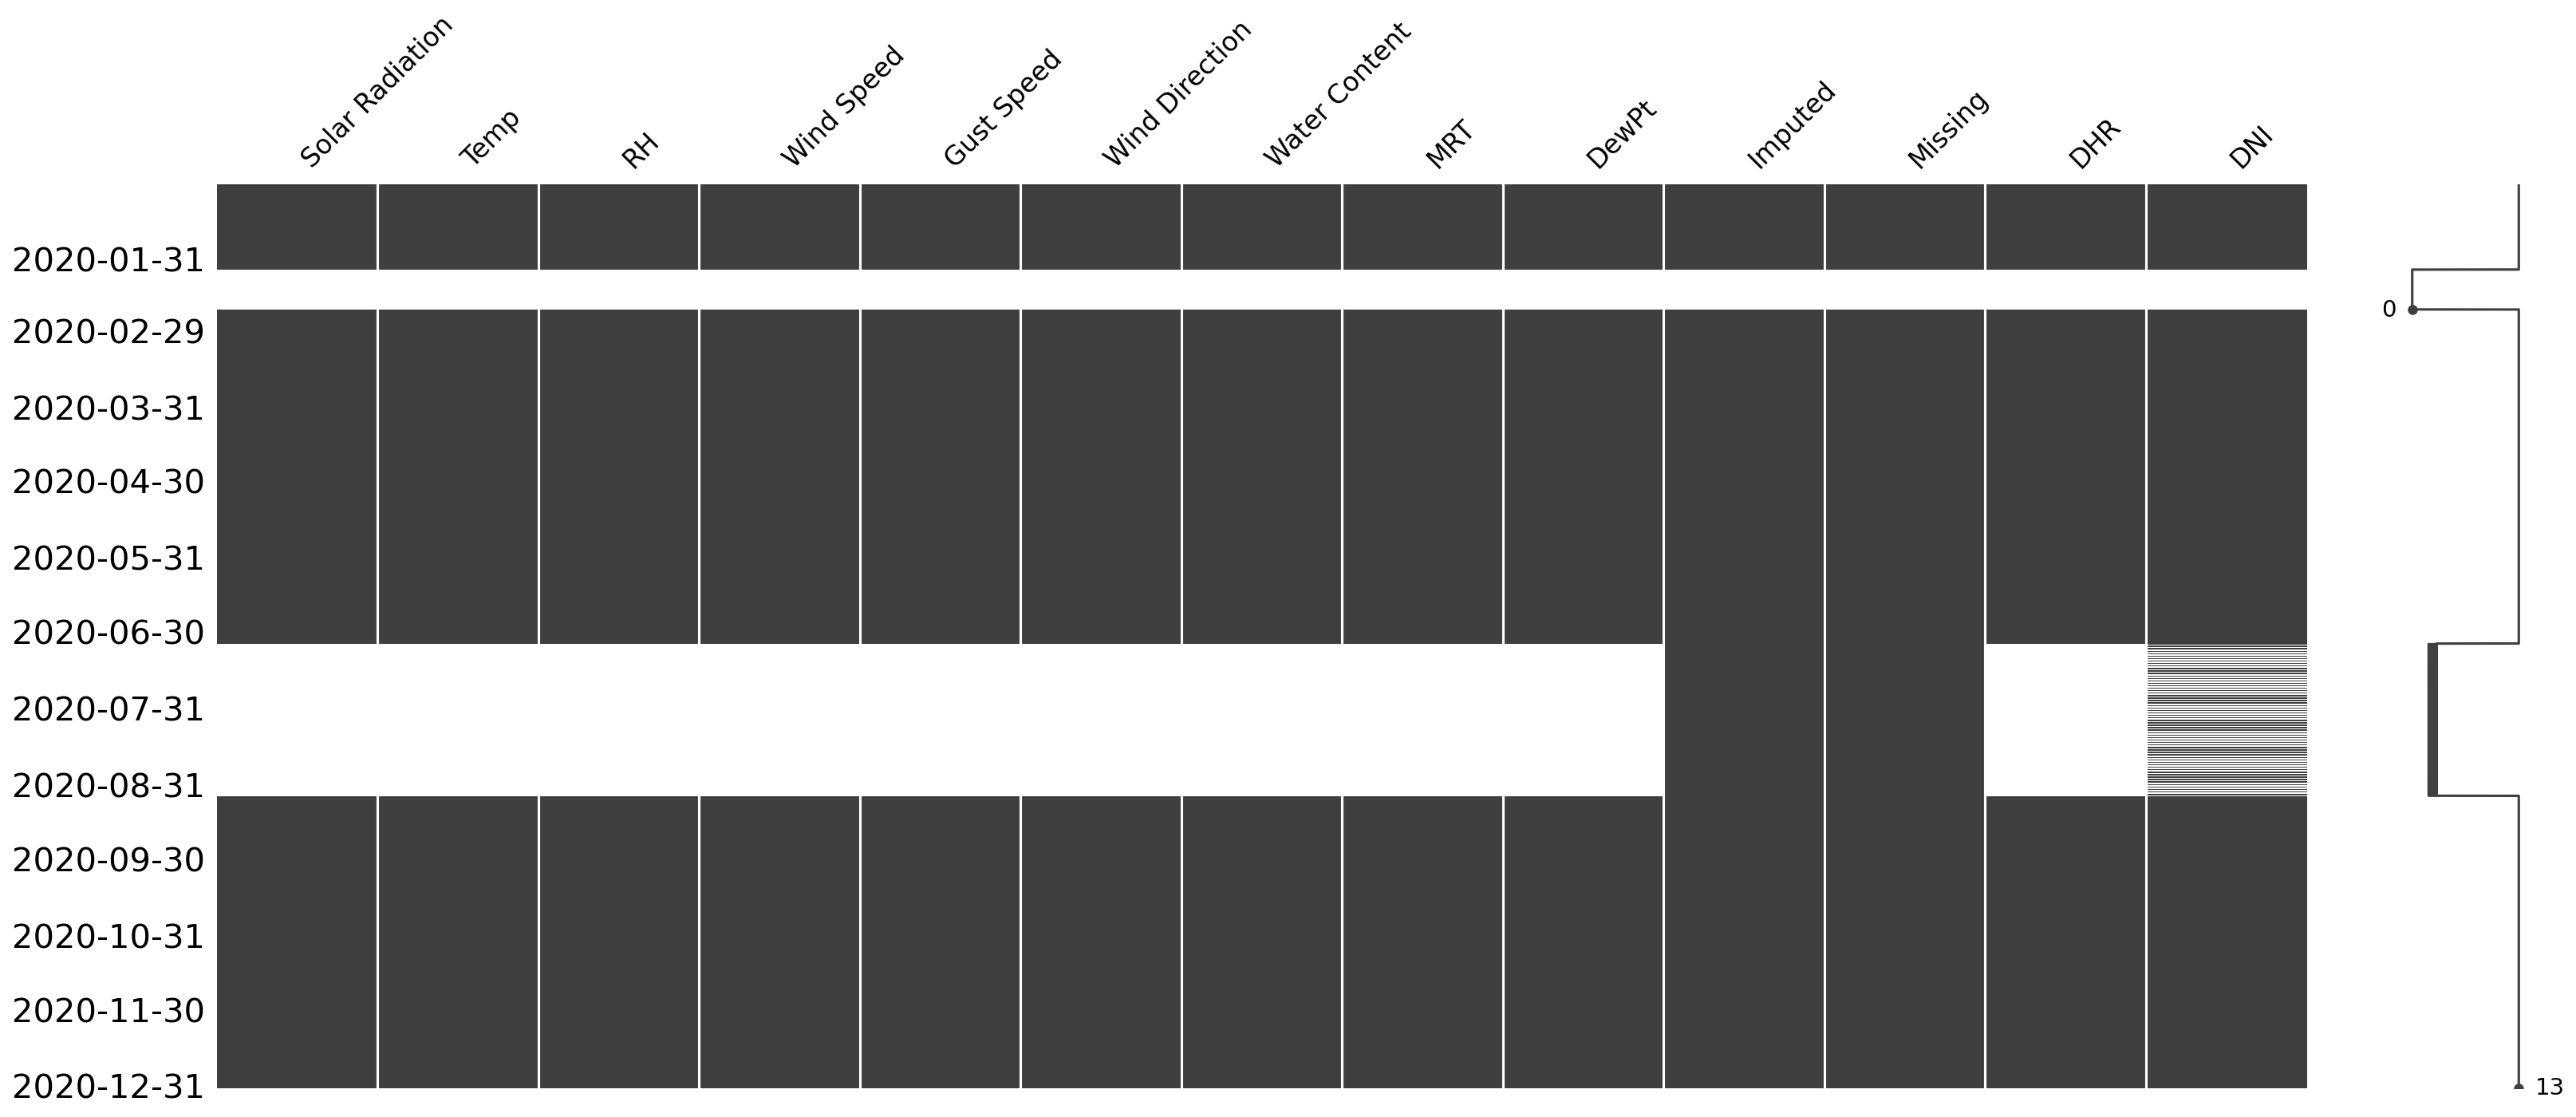

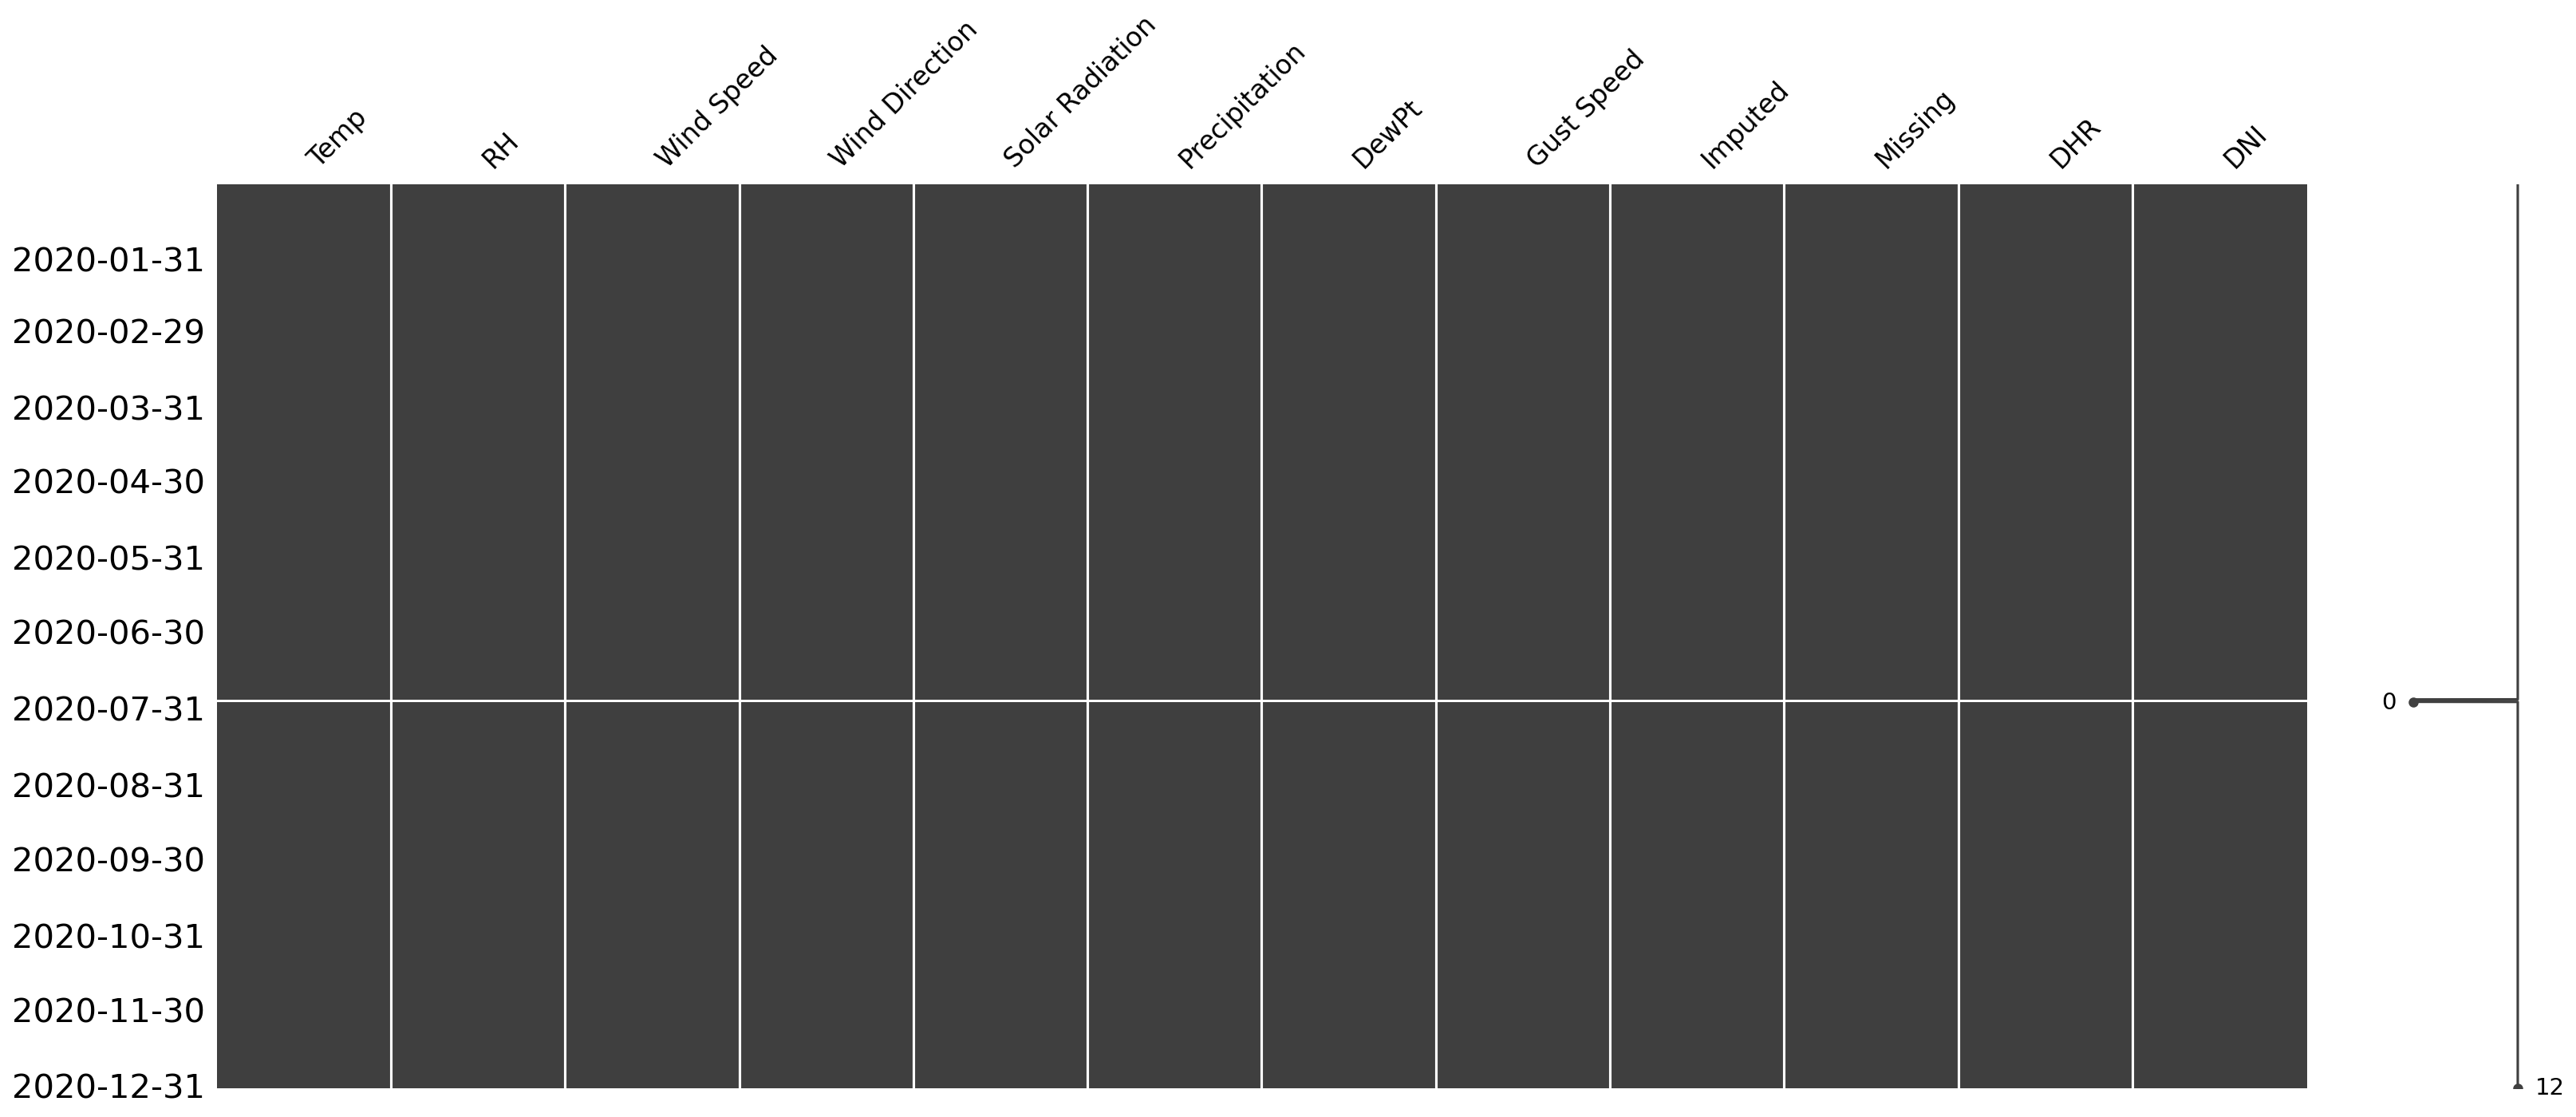

In [185]:
# Remove leap year


make_epw("DL1_NoLeap", 2020, df1, True)
make_epw("DL2_NoLeap", 2020, df2, True)
make_epw("DL3_NoLeap", 2020, df3, True)
make_epw("DL4_NoLeap", 2020, df4, True)
make_epw("GameFarmRoad_NoLeap", 2020, df5, True)

In [195]:
df5.iloc[4970:5010,:]

title,#,Date Time,Temp,RH,Wind Speed,Wind Direction,Solar Radiation,Precipitation,DewPt,SkyCover,Gust Speed,Imputed,Missing,DHR,DNI
datetimes,,,,,,,,,,,,,,,
2019-07-27 00:00:00+00:00,4970,07/27/19 02:00:00 AM,16.67,95.0,0.800,73.0,0.00,0.00,15.67,0,1.140,0,0,0.000000,0
2019-07-27 01:00:00+00:00,4971,07/27/19 03:00:00 AM,16.17,95.0,0.899,81.0,0.00,0.00,15.17,0,1.158,0,0,0.000000,0
2019-07-27 02:00:00+00:00,4972,07/27/19 04:00:00 AM,16.00,95.0,0.899,80.0,0.00,0.00,15.00,0,1.238,0,0,0.000000,0
2019-07-27 03:00:00+00:00,4973,07/27/19 05:00:00 AM,15.56,95.0,0.818,79.0,0.00,0.00,14.56,0,1.059,0,0,0.000000,0
2019-07-27 04:00:00+00:00,4974,07/27/19 06:00:00 AM,15.06,97.0,0.939,59.0,0.00,0.00,14.46,0,1.198,0,0,0.000000,0
2019-07-27 05:00:00+00:00,4975,07/27/19 07:00:00 AM,15.28,96.0,0.621,99.0,40.71,0.00,14.48,0,1.019,0,0,40.710000,0
2019-07-27 06:00:00+00:00,4976,07/27/19 08:00:00 AM,18.44,85.0,1.140,140.0,153.52,0.00,15.44,0,1.819,0,0,53.265519,537
2019-07-27 07:00:00+00:00,4977,07/27/19 09:00:00 AM,21.61,76.0,1.319,138.0,309.36,0.00,16.81,0,2.021,0,0,109.654157,542
2019-07-27 08:00:00+00:00,4978,07/27/19 10:00:00 AM,23.94,68.0,1.118,162.0,474.50,0.00,17.54,0,1.819,0,0,158.160551,586


In [ ]:
a = epw()
a.read("DL4_Milstein_2019.epw")
day = 8
month = 12
year = 2019

hour_f = to_hour_of_year(0, day, month, year)
hour_t = to_hour_of_year(23, day, month,year)

print(hour_f, hour_t)

pd.set_option('display.max_rows', None)
a.dataframe.loc[hour_f-48:hour_t+48,['Wind Speed', 'Wind Direction']]
#a.dataframe.loc[:,['Wind Speed', 'Wind Direction']]

#display(a.dataframe)
